# Data Reduction Tutorial
## A tutorial for the data reduction procedures from Cheng et al. (in prep)

# Introduction
This notebook will take you through how the data reduction was done for Cheng et al. (in prep).  The initial data reduction is done using PypeIt, which we will go through in detail first.  Several external procedures were also written outside of PypeIt, including the flexure and telluric corrections.  Code and examples for these procedures will be provided here.

This tutorial is meant to take you through the procedure step-by-step.  Specifically, this is the logical order in which I would complete a full data reduction, so you should be able to follow this tutorial as is.  Feedback, suggestions, and questions are welcome!  Feel free to shoot me an [email](mailto:cmtcheng@uwaterloo.ca).

# PypeIt Data Reduction
The PypeIt documentation is extensive and helpful, and I will refer to it throughout this tutorial.  In particular, check out the [PypeIt Cookbook](https://pypeit.readthedocs.io/en/release/cookbook.html) to get started (I have adapted some of the steps from here and added details and examples to fit this project).  I also recommend joining the [PypeIt Users Slack workspace](https://github.com/pypeit/PypeIt/issues/676) - this is where you can ask the developers questions.  They are very responsive and helpful!

## Installation
Follow the instructions [here](https://pypeit.readthedocs.io/en/release/installing.html).  Be sure to install the [Atmospheric Model Grids](https://pypeit.readthedocs.io/en/release/installing.html#atmospheric-model-grids), which we will use later, and make sure [ginga](https://pypeit.readthedocs.io/en/release/installing.html#ginga-plugins) is working.  

## Setup
Ostensibly, you only need to do this step once for each of the objects that you are reducing (even if you end up having to re-reduce the data for whatever reason).  

0. Following step [0](https://pypeit.readthedocs.io/en/release/cookbook.html#organize-prepare-your-data) in the PypeIt Cookbook, organize your data so that you have one directory for each individual object you are reducing.  The directory should contain all science and calibration frames (you may have to copy your calibration frames into several different directories if you have one set for all of your observations).  **Note that for Keck LRIS, you must reduce the blue and red sides separately**.  So, for example, if I am reducing a globular cluster, I will have one directory for the blue science + calibration frames for this GC and one directory for the red science + calibration frames for this GC.  Note that there are many different possible frametypes that can be used in defined in PypeIt.  However, I have found that at a minimum you need `science` frames, `arc,tilt` (tilts), and `pixelflat,illumflat,trace` (flat field) frames.

1. Following step [1](https://pypeit.readthedocs.io/en/release/cookbook.html#setup), [setup](https://pypeit.readthedocs.io/en/release/setup.html) your reduction.  Change your working directory to one where you would like your reduced data to live (I prefer to work in the directory where my raw files are located).  Run the following command: `pypeit_setup -r <path_to_raw_data> -s <instrument_name>`.  So, for example, if you are reducing data from the Keck LRIS blue arm, and if your raw data is located in `/Users/janedoe/object_name/blue/`, you would run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue`.  The options are required:
- `-r` = path to raw data
- `-s` = instrument
This will create a directory called `setup_files`, which will contain the (relevant) file `<spectrograph>_<date>.sorted`

2. Open the `.sorted` file and inspect it.  It will contain each instrument setup that was used in the collection of your data (labelled A, B, C, ...) and a list of frames associated with each.  For each instrument setup, there will be a setup block at the beginning of the section which describes the instrument configuration.  This will be followed by the list of frames, which will automatically have some information assigned to them based on their headers.  Importantly, PypeIt will automatically assign a frametype to each frame (i.e. science, standard, etc.).  Use this file to decide which configuration you would like to reduce (this will be the one where all of your science frames are located).  Below is an example for the M31 GC B058 - in this case I would want to be using Setup A.

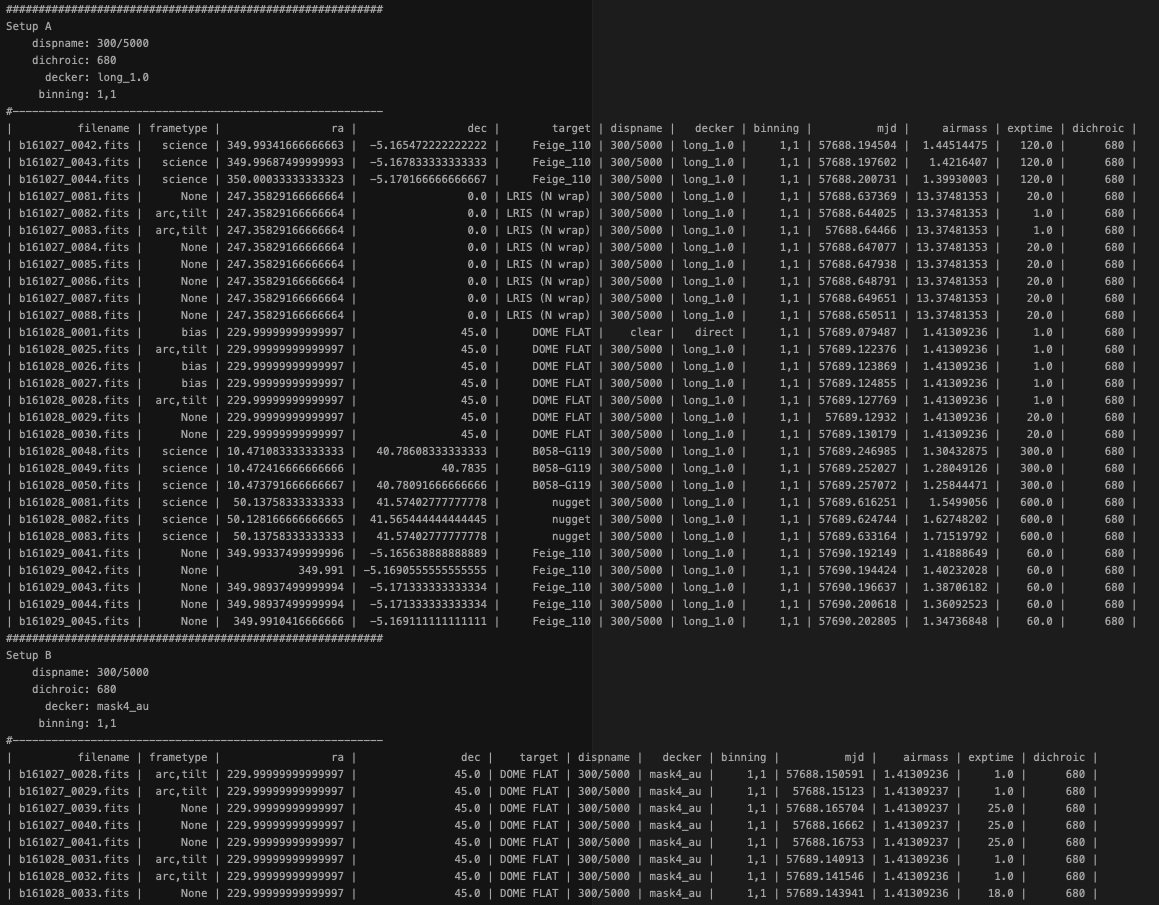

3. Re-run `pypeit_setup` for the setup(s) that you want.  You can do this using the `-c` option.  For example, since I want to use Setup A, I would run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue -c A`, which will generate one directory (`keck_lris_blue_A`) and one `.pypeit` file (`keck_lris_blue_A.pypeit`) for this setup.  If you wanted to use two setups, you could run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue -c A,B` and if you wanted to access all of the setups you could run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue -c all`.  The `.pypeit` file is very important and is what you will use to specify parameters for your reduction. 

## Reduction
### Examining your `.pypeit` reduction file
Open your `.pypeit` reduction file.  Here is an example, using the same object as above:

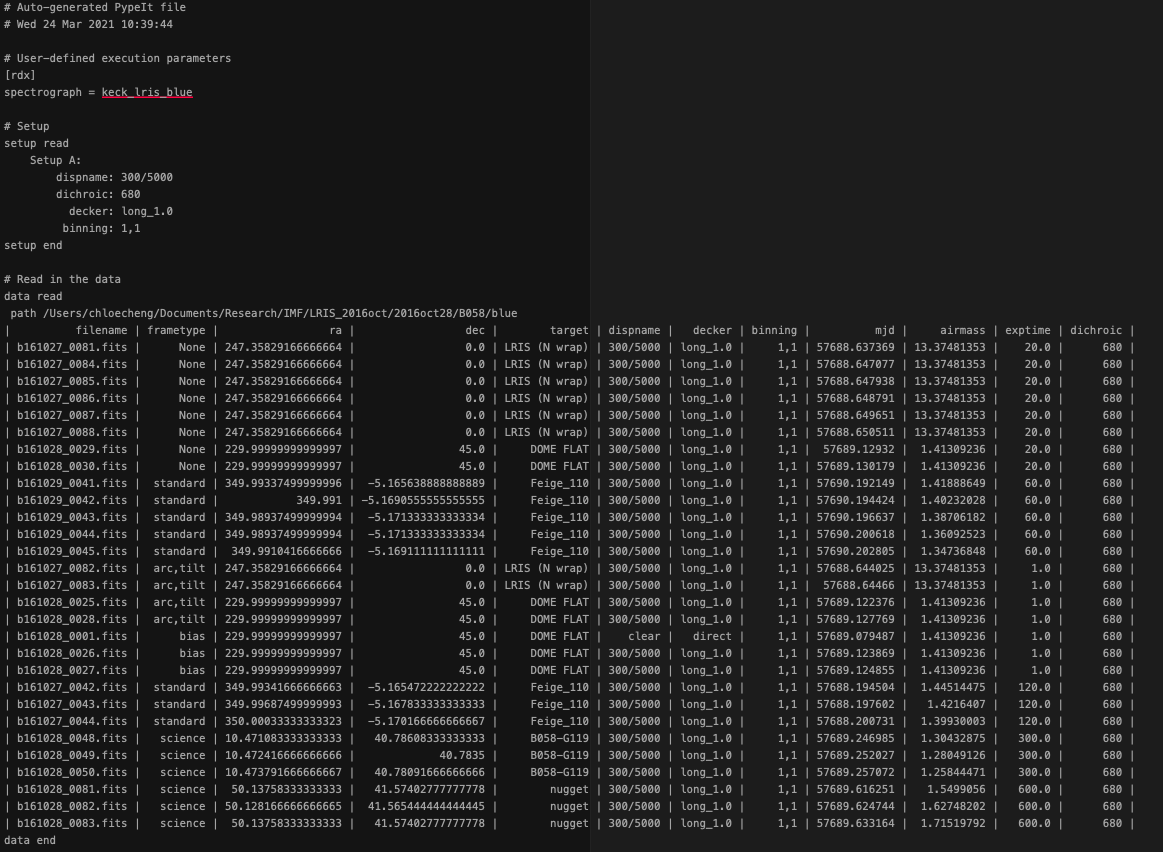

The block under `# User-defined execution parameters` at the top of the file is called the parameter block.  PypeIt will by default add your instrument here under `spectrograph`, but there are several other options that you can add to clarify your reduction, which we will review below.  Underneath this, under `# Setup` is your setup block, which describes your instrument configuration.  You will not need to touch this.  Finally, below this, under `# Read in the data` is your data block, which lists all of the `.fits` files that PypeIt found in your directory.  PypeIt reads in most of the information here from the `.fits` headers.  It also automatically assigns a frametype in the second column - you may need to make adjustments here if PypeIt makes an incorrect assignment, which we will go over as well.  

### Editing the Data Block
Sometimes, PypeIt will incorrectly assign a frametype.  If you know what the frametype should be, you can change this yourself.  For example, in the image below, I have circled two frames where PypeIt thinks the frametype is "None":

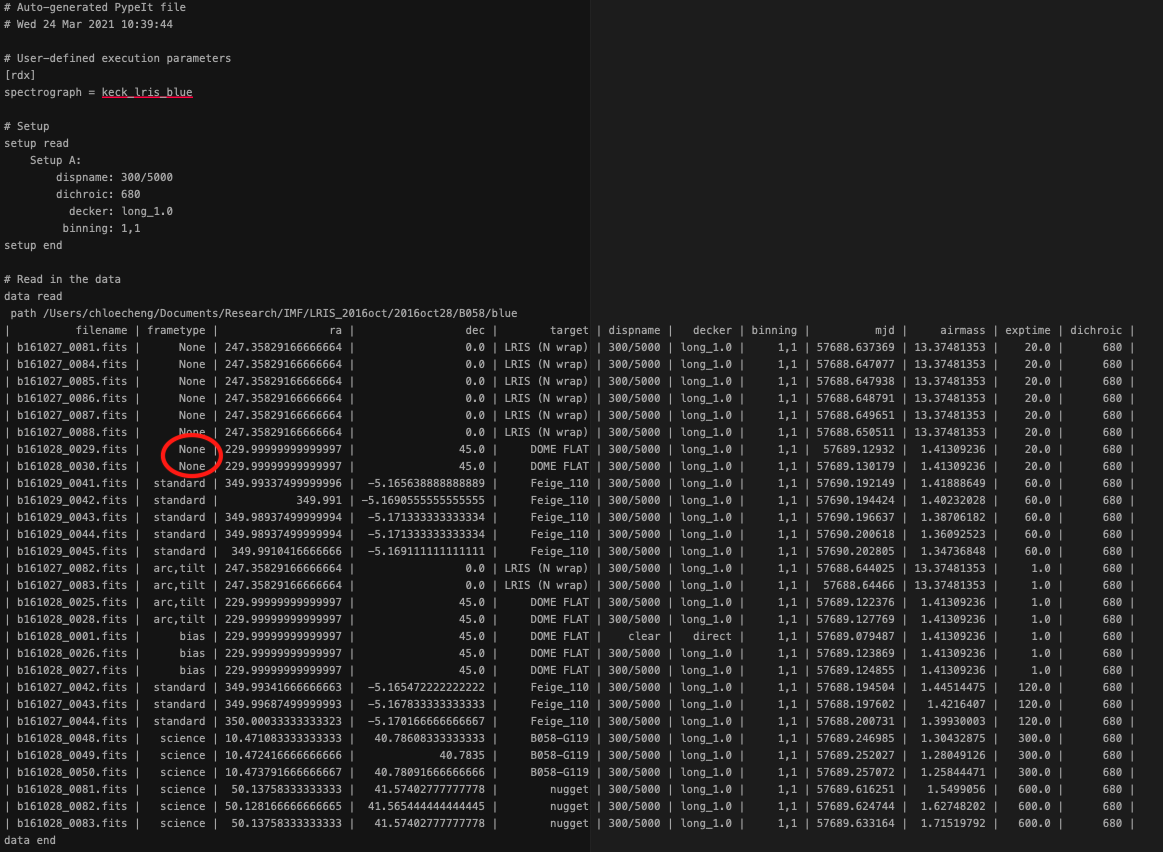

However, I know that these are actually flat field frames, so I can change them as such:

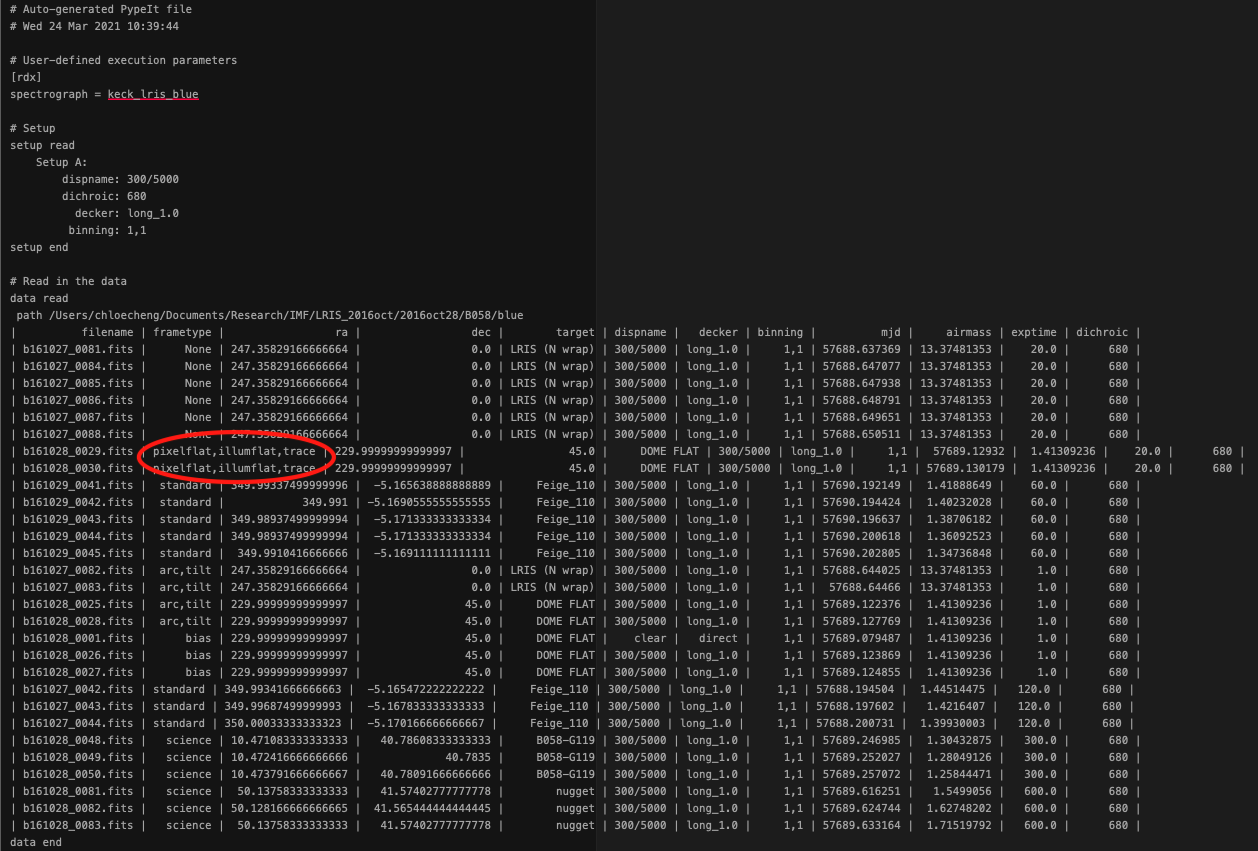

(We'll go over what `pixelflat,illumflat,trace` means in more detail later.)  Other common mistakes that can be made are assigning science frames as standard frames and vice versa. 

Additionally, you may notice that there are several frames where the frametype or other fields are labelled as `None`.  PypeIt will not run if there are fields containing `None`, so you must either modify them (as described above), or remove them from your reduction (by commenting out or deleting the corresponding lines).

### Editing the Parameter Block
PypeIt is flexible in that you can make a wide variety of edits to the parameter block to customize your reduction for your purposes.  Here I'll go through some useful options, and particularly parameters that I made use of in my research.  A full list of the specific parameters used for each object in this study can be found [here](https://docs.google.com/spreadsheets/d/1m1rKS0QG10h7SWaI_GeKfeycSdpiG8CUI_eKOeBhJnY/edit?usp=sharing).  An extensive overview of all of the possible parameters that can be changed in PypeIt is given [here](https://pypeit.readthedocs.io/en/release/pypeit_par.html).

#### [Bias, Darks](https://pypeit.readthedocs.io/en/release/bias_dark.html), and [Flat Fielding](https://pypeit.readthedocs.io/en/release/flat_fielding.html)
You may have frames of all of these types, in which case edits will not necessarily need to be made here.  However, you may not have certain frametypes, or you may not want to use certain frames.  In that case, you can make several customizations under the `[baseprocess]` parameter group.  This is how you can format the parameter group:
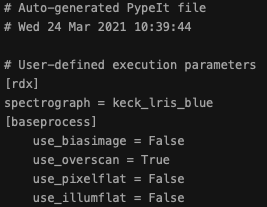

Listed in the image are the parameters that I found useful, which I used for all of my objects:
- `use_biasimage = False`: I did not have bias frames, so I turned off the default biasing
- `use_overscan = True`: I still wanted to bias my frames, so I turned on overscan bias subtraction
- `use_pixelflat = False` and `use_illumflat = False`: I turned off flat fielding.  This is suggested for Keck LRIS by the PypeIt developers (**I think, check this**), and is pretty common for spectroscopic studies.  You will still need to have flat field frames defined as they will need to be used for slit tracing, which we will discuss below.

#### [Calibrations](https://pypeit.readthedocs.io/en/release/calibrations.html)
Many parameters in the `[calibrations]` parameter block can be changed to customize various steps of the calibrations that PypeIt performs.  The order in which calibrations are performed are:
1. Bias and dark subtraction
2. Slit tracing
3. Flexure correction
4. Wavelength calibration
5. Flat fielding

I will go through some key parameter changes that I found useful for some of these steps. 

##### [Slit tracing](https://pypeit.readthedocs.io/en/release/slit_tracing.html)
Slit tracing can be very finnicky.  The biggest issue that I had was PypeIt identifying too many slits (for my purposes, I only had one slit because I was using Keck longslit data).  Here are some parameters in the `[[slitedges]]` sub-block that can help fix this:
- `minimum_slit_length`: The minimum length of the slit in arcseconds.  By trial and error, I usually set this to 10 for blue frames.
- `edge_thresh`: Threshold for finding slit edges.  By trial and error, I usually set this to 50 for red frames. 
- `add_slits`: Sometimes a slit was missing or I could not get the slit to be identified in the correct place.  Then I would manually add a slit using the `add_slits` parameter.  The syntax for this is detector:spectral pixel:spatial pixel of left slit boundary:spatial pixel of right slit boundary.  So, for example, if you want to add a slit on detector 2 at spectral pixel 2000 from spatial pixels 1 to 328, you would define `add_slits = 2:2000:1:328`.  You can mouse over the 2D spectrum in `ginga` during the reduction in debug (`-s`) mode or after the reduction to estimate these pixel placements.  I mainly found this useful for my data taken in Apr. 2017 (typically, either data taken on the same night or data for objects of the similar type will be reduced in very similar ways).
- `rm_slits`: Sometimes you need to remove an extra slit, i.e. in some cases I found that PypeIt wouldn't stop identifying 2 slits or more.  The syntax for this is detector:spectral pixel:spatial pixel.  So, for example, if you want to remove a slit on detector 2 at spectral pixel 2000 and spatial pixel 363, you would define `rm_slits = 2:2000:363`.  If you wanted to remove an additional slit, you could define `rm_slits = 2:2000:363,2:2000:696`.  Again, you can mouse over the 2D spectrum to estimate these pixels.  I mainly found this useful for my data taken in Dec. 2014.

##### Wavelength calibration
Here are some parameters in the `[[wavelengths]]` sub-block:
- `n_first`: Order to try first for wavelength calibration fit
- `method`: Method for wavelength calibration (default on blue side is `full_template`, usually just changed red side to match)
- `reid_arxiv`: Need for red side
- `sigdetect`:
- `match_toler`: 

I should also note here that I defined my own wavelength calibration for the red detector.  The calibration has been included in PypeIt so you won't need to do this if you are reducing data exactly as I describe here.  However, in case such a need arises, I will go over how I did this here.

*Add instructions*

#### Main reduction run
Other important procedures include:
1. Object finding
2. Spectral extraction
3. Sky subtraction
4. Flexure correction

These can be modified in the `[reduce]` parameter block.

##### Object finding
Here are some parameters in the `[[findobj]]` sub-block:
- `sig_thresh`:
- `maxnumber`: Maximum number of objects to extract from the slit (1 in this case)
- `find_fwhm`: FWHM of the object to be extracted (helps PypeIt detect the object if the FWHM is small)
- `find_trim_edge`:

##### Extraction
Here are some parameters in the `[[extraction]]` sub-block:
- `use_2dmodel_mask`:
- `use_user_fwhm`: only important for NGC 247
- `boxcar_radius`: only important for NGC 247

##### Sky subtraction
Here are some parameters in the `[[skysub]]` sub-block:
- `sky_sigrej`: 

##### Flexure correction
Since we do our own flexure correction procedure, we need to turn off the flexure correction in one copy of the reduction, in the `[[flexure]]` sub-block:
- `spec_method`:

### Running PypeIt
Once you have edited your `.pypeit` reduction file, you are ready to run the reduction.  Detailed instructions can be found [here](https://pypeit.readthedocs.io/en/release/running.html).  Enter the directory that corresponds to your desired setup (i.e. `keck_lris_blue_A`).  You can then run the `run_pypeit` script, which is the main script to reduce your data.  A standard call is something like `run_pypeit <filename.pypeit> -o`.  For our example, we would run `run_pypeit keck_lris_blue_A.pypeit -o`.  The option `-o` tells PypeIt to overwrite existing files and directories (i.e. if you are re-running a reduction).  This is recommended.  

#### Running in debug mode
Another relevant flag that you can use is the `-s` flag, which runs PypeIt in debug mode.  This will generate several plots while the reduction is running, and you can check these out to make sure your data is being reduced as desired.  Note that this option is a little bit slower, as there are some plots which must be closed by the user before the reduction will proceed to the next step.  I mainly use this when I am tuning parameters in the Parameter Block.  Here are some examples of how you can make use of the debug mode.

*Some examples, i.e. trying to get rid of multiple objects or identifying the correct object, using it to adjust slits, checking overmasking (I think), etc.)*

*Also need to add detector 2 thing*

### Examine your Spectra
PypeIt should produce one 1D spectrum and one 2D spectrum for each science and standard frame in your reduction. If you are missing spectra, this means that PypeIt did not find any objects in the corresponding frame and you probably need to tune your Parameter Block.  You should quickly examine each spectrum to make sure your reduction went as desired before moving on.  

#### 2D Spectra
To examine the 2D spectra, you can use the `pypeit_show_2dspec` script (details [here](https://pypeit.readthedocs.io/en/release/out_spec2D.html)).  This makes use of the `ginga` viewer.  Sometimes you can just run `pypeit_show_2dspec` as is and it will work, but I've found that sometimes I need to launch `ginga` using a separate terminal window.  You can do this using the command `ginga --modules=RC` (this launches `ginga` using the `RC` plugin).  Then, you can view a 2D spectrum using the command `pypeit_show_2dspec <path_to_2d_spectrum.fits>`.  For example, if you are working in your setup sub-directory (i.e. `keck_lris_blue_A`), then you can call `pypeit_show_2dspec Science/spec2d_b161028_0048-B058-G119_LRISb_20161028T055539.504.fits`, or if you enter the `Science` subdirectory where your spectra are outputted by PypeIt first, you can just call `pypeit_show_2dspec spec2d_b161028_0048-B058-G119_LRISb_20161028T055539.504.fits`.  If you only reduced the object on one detector, then you need to specify this: `pypeit_show_2dspec Science/spec2d_b161028_0048-B058-G119_LRISb_20161028T055539.504.fits --det=2`.  Your `ginga` window should look something like this: 

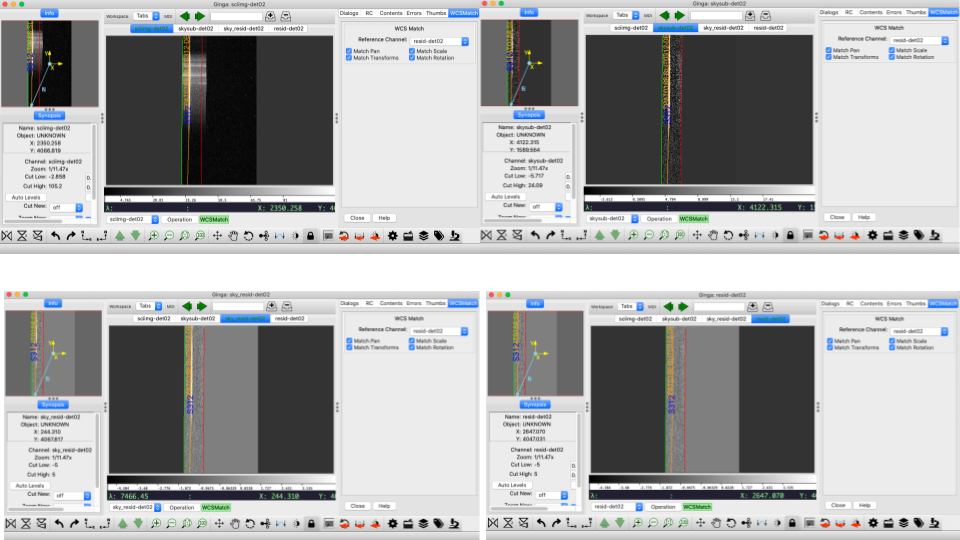

There are four tabs: 
1. `sciimg`: Processed science image (above).  The bright vertical stripe is your object, 
2. `skysub`: Sky-subtracted science image 
3. `sky_resid`: Sky residual image
4. `resid`: Full residual image (object removed too)

In each frame, the bright vertical stripe is your object, the orange line is the trace identified by PypeIt for your object, and red and green lines indicate the slit edges.  The `ginga` viewer is interactive, so you can zoom in on your trace or pan around your frame.

#### 1D Spectra
To examine the 1D spectra, you can use the `pypeit_show_1dspec` script (this does not use `ginga`, details [here](https://pypeit.readthedocs.io/en/release/out_spec1D.html)).  Simply call `pypeit_show_1dspec <path_to_1d_spectrum.fits>`.  For our example, you can call `pypeit_show_1dspec Science/spec1d_b161028_0048-B058-G119_LRISb_20161028T055539.504.fits`.  Since we are only looking at one object in each frame, this is all you have to do.  If you had multiple objects, however, you could examine each of them using the `--exten` flag: `pypeit_show_1dspec Science/spec1d_b161028_0048-B058-G119_LRISb_20161028T055539.504.fits --exten 1`.  Here is an example of what you should see:

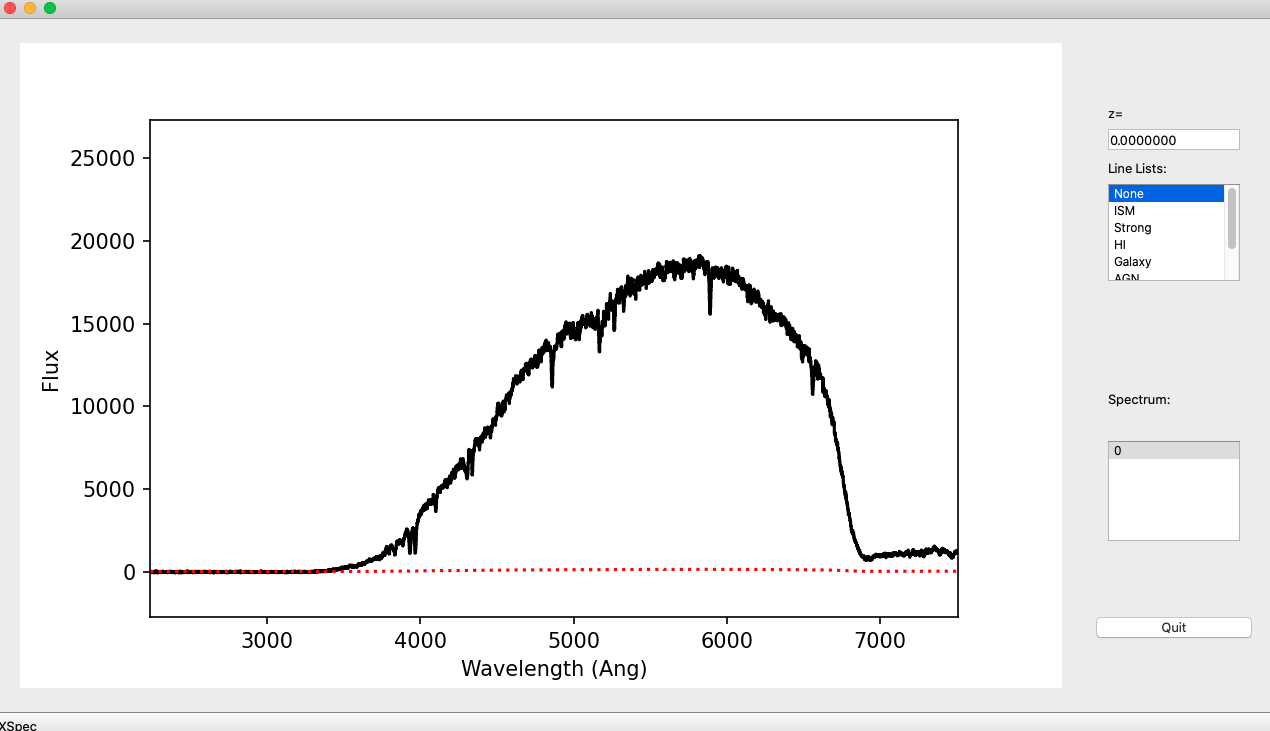

There is some interactivity (i.e. you can click to put down lines), but I haven't found it to be terribly useful for my purposes.

Each 1D spectrum also has a corresponding `.txt` file with useful information like the S/N:

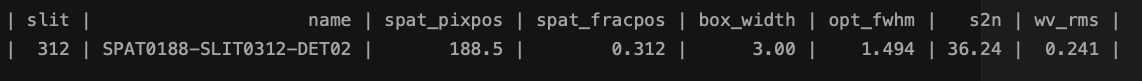

### Fluxing
You can flux your spectra.  I did not use this functionality, but details can be found [here](https://pypeit.readthedocs.io/en/release/fluxing.html).  This is run separately, outside of the main run, once the `run_pypeit` script is finished and has outputted all of your spectra and calibration frames.

### Coadding
This is the last step that we will do using the PypeIt framework.  I specifically [coadd the 1D spectra](https://pypeit.readthedocs.io/en/release/coadd1d.html) only, but there is functionality for [coadding the 2D spectra](https://pypeit.readthedocs.io/en/release/coadd2d.html) and [3D spectra](https://pypeit.readthedocs.io/en/release/coadd3d.html) as well.

Coadding essentially means combining multiple frames from the same object.  This typically results in higher S/N for your object.  To coadd the 1D spectra, you will first need to produce a `.coadd1d` file.  You can write this yourself, or you can use the `pypeit_flux_setup` script: `pypeit_flux_setup <path_to_science_frames>` (i.e. `pypeit_flux_setup /Users/janedoe/object_name/blue/keck_lris_blue_A/Science/`).  This is meant to be used to produce a file for fluxing (`.flux`), but it will also produce a `.tell` file and a `.coadd1d` file.  You can ignore the `.flux` and `.tell` files.  

Open the `.coadd` file, which should look something like this:

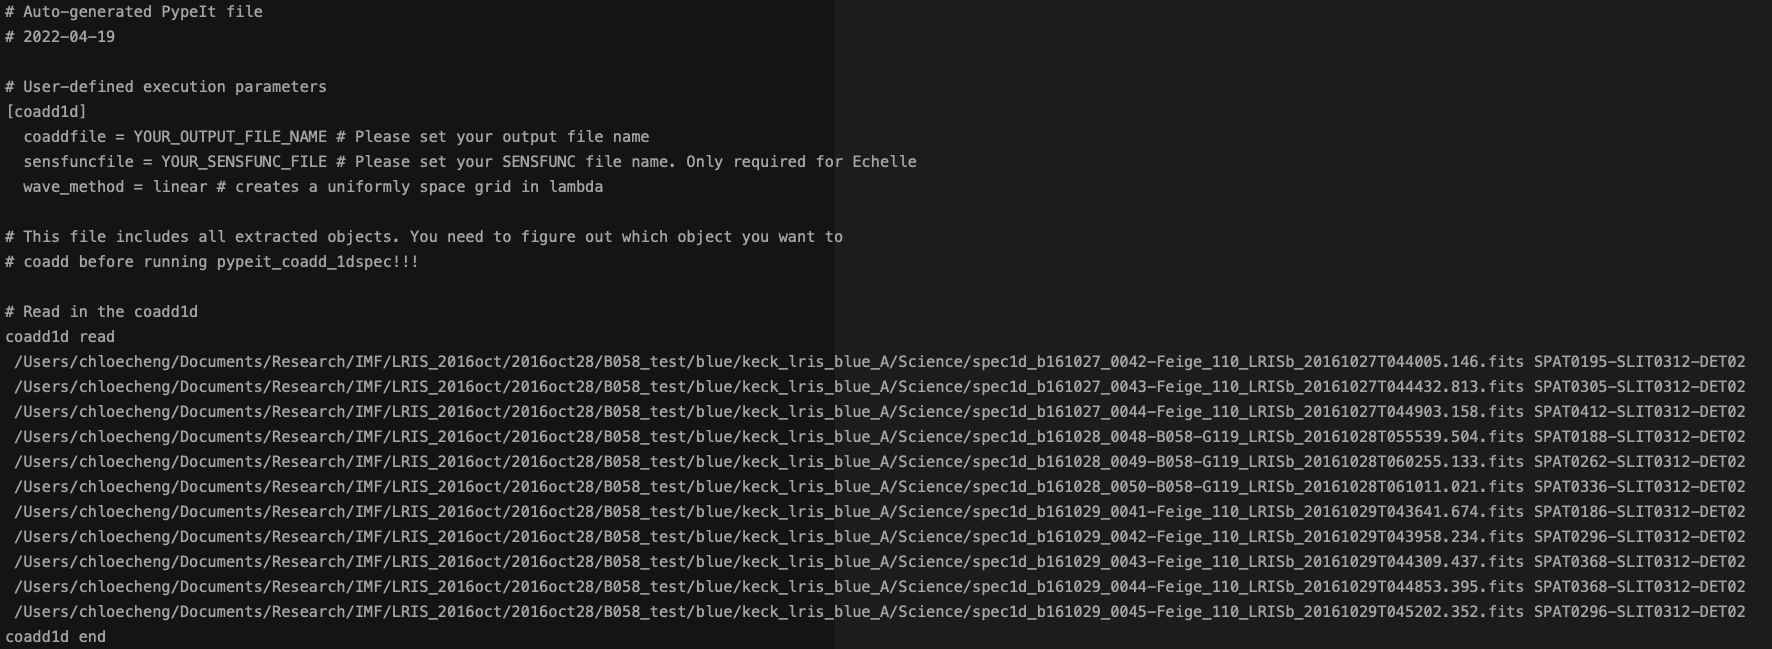

You will have to edit the Parameter Block here as well.  Most relevantly, you will need to set your output file name.  For our purposes, we do not need the `sensfuncfile` so you can comment that line out or delete it.  I also choose to add the following parameters:
- `wave_method = iref`: This gets rid of some weird issues with how the spectral uncertainty looks - see more options [here](https://pypeit.readthedocs.io/en/release/pypeit_par.html#coadd1dpar-keywords).
- `flux_value = False`: Make sure to turn off fluxing because we did not flux our spectra.

Underneath this block is a list of files to be coadded and the corresponding object trace.  You will notice that PypeIt automatically lists all frames here, including some frames that are from a different object.  You will need to remove these and include only the frames that you are interested in coadding.

This is what my final `.coadd` file looks like:

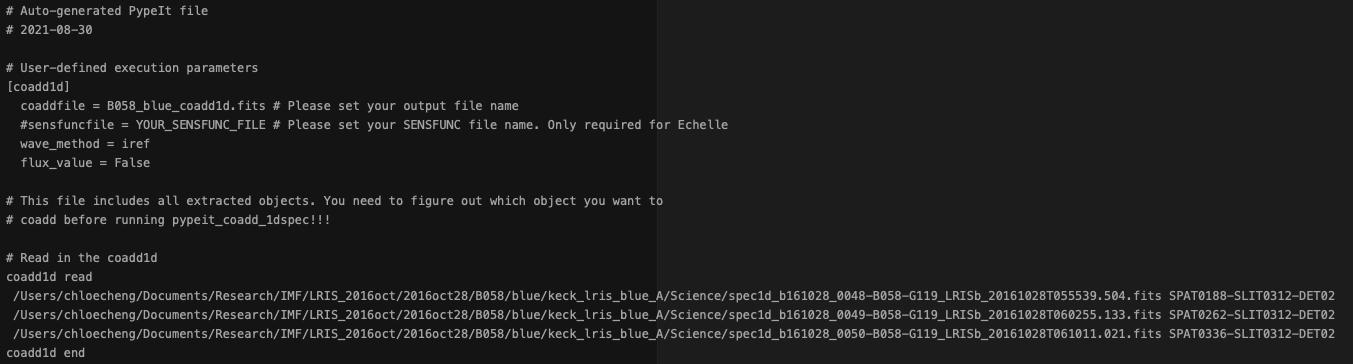

You can then use the `pypeit_coadd_1dspec` script to coadd the files: `pypeit_coadd_1dspec <coadd_file_name.coadd1d>` (i.e. `pypeit_coadd_1dspec keck_lris_blue.coadd1d`).  There are some flags that you can use, but I didn't find them particularly useful.  This will produce a single `.fits` file, where your final, coadded spectrum will be.  

You can also check what your co-added spectra look like using the command `lt_xspec <coadd1d_file.fits>` (i.e. `lt_xspec B058_blue_coadd1d.fits`.  Here are examples of blue and red coadded spectra for B058:

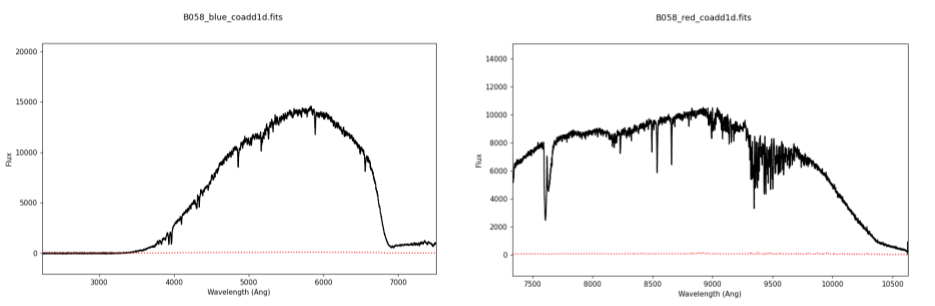

This is the final data product from PypeIt and I will use the coadded spectra going forward.

# External Data Reduction Routines
Here I will go through guided tutorials for the external data reduction routines that I wrote, outside of PypeIt.  These include:
1. Flexure correction
2. Telluric correction

## Flexure correction
*Need to talk about doing reduction with and without flexure correction somewhere*

The flexure correction functions and routines are defined in [`flexure_correction.py`](https://github.com/chloe-mt-cheng/imf_css/blob/main/flexure_correction.py), but I will go through them here in more detail and provide some more instruction.  First, let's do some imports:  

In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.io.ascii
import astropy.units as u
from astropy.nddata import StdDevUncertainty, InverseVariance, VarianceUncertainty
from astropy.modeling import models
from sedpy.observate import air2vac
from prospect import utils
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
import glob
from specutils.analysis import centroid
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
import matplotlib.pyplot as plt

font = {'family':'serif',
        'weight':'normal',
        'size':20
}
plt.rc('font',**font)

Let's also go ahead and import the example data for B058 that we have been working with so we can go through some concrete examples as I define the code:

In [2]:
#Blue data
B058_blue_coadd_file = fits.open('B058_blue_coadd1d.fits')
B058_blue_coadd_wave = B058_blue_coadd_file[1].data['wave']
B058_blue_coadd_flux = B058_blue_coadd_file[1].data['flux']
B058_blue_coadd_noise = np.sqrt(B058_blue_coadd_file[1].data['ivar'])

#Red data
B058_red_coadd_file = fits.open('B058_red_coadd1d.fits')
B058_red_coadd_wave = B058_red_coadd_file[1].data['wave']
B058_red_coadd_flux = B058_red_coadd_file[1].data['flux']
B058_red_coadd_noise = np.sqrt(B058_red_coadd_file[1].data['ivar'])

Now we need to define some continuum-normalization code.  This is based on the continuum-normalization defined in Conroy et al. 2018, where we fit a high-order polynomial to the segment of the spectrum that we want to normalize (where the order is defined as 
$$n = (\lambda_{\mathrm{max}} - \lambda_{\mathrm{min}})/100\mathrm{ Å}\label{eq:n}\tag{1}$$ 
within each wavelength interval) and divide this out of the spectrum.  The first function (`data_ranges`) separates your data out into desired wavelength chunks (I recommend always separating your data into smaller chunks as opposed to normalizing the entire wavelength range of the spectrum - if you do this you probably won't be able to find a polynomial that fits to your whole data).  The second function (`poly_order`) finds the order of the polynomial defined in Equation \ref{eq:n}.  The third function (`continuum_normalize`) does the actual normalization of your spectral segment.  It calls the first two functions.

In [3]:
#############################################################
# Continuum-normalization functions (also normalizes noise) #
#############################################################
def data_ranges(lambda_min, lambda_max, flux, wavelength, noise):
    """Return the data within the desired wavelength range.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range 
    lambda_max : float
        The upper bound of the wavelength range
    flux : tuple
        The flux data
    wavelength : tuple
        The wavelength data
    noise : tuple
        The noise data
        
    Returns
    -------
    wavelength_inrange : tuple
        The wavelength data within the desired wavelength range
    flux_inrange : tuple
        The flux data within the desired wavelength range
    noise_inrange : tuple
        The noise data within the desired wavelength range
    """
    
    rng = (wavelength >= lambda_min) & (wavelength <= lambda_max)
    wavelength_inrange = wavelength[rng]
    flux_inrange = flux[rng]
    noise_inrange = noise[rng]
    return wavelength_inrange, flux_inrange, noise_inrange

def poly_order(lambda_min, lambda_max):
    """Return the order of the polynomial by which to continuum-normalize the spectrum.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
        
    Returns
    -------
    (lambda_min/lambda_max)/100 : int
        The order of the polynomial by which to continuum-normalize the spectrum
    """
    
    return int((lambda_max - lambda_min)/100)

def continuum_normalize(lambda_min, lambda_max, flux, wavelength, noise):
    """Return the spectrum normalized by the fitted polynomial shape of the continuum.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
    flux : tuple
        The flux data
    wavelength: tuple
        The wavelength data
    noise : tuple
        The noise data
        
    Returns
    -------
    wavelength_inrange : tuple
        The wavelength data within the desired wavelength range
    flux_norm : tuple
        The continuum-normalized flux within the desired wavelength range
    noise_norm : tuple
        The continuum-normalized noise within the desired wavelength range
    """
    
    #Get the data in the desired wavelength range
    wavelength_inrange, flux_inrange, noise_inrange = data_ranges(lambda_min, lambda_max, flux, wavelength, noise)
    
    #Get the order of the polynomial 
    n = poly_order(lambda_min, lambda_max)
    
    #Fit an nth-order polynomial to the spectrum
    xrange = np.linspace(np.min(lambda_min), np.max(lambda_max), len(wavelength_inrange))
    polynomial_fit = np.polyfit(xrange, flux_inrange, n)
    poly_obj = np.poly1d(polynomial_fit)
    
    polynomial_fit_noise = np.polyfit(xrange, noise_inrange, n)
    poly_obj_noise = np.poly1d(polynomial_fit_noise)
    
    #Divide out the fitted polynomial to get a continuum-normalized spectrum
    flux_norm = flux_inrange/poly_obj(xrange)
    noise_norm = noise_inrange/poly_obj_noise(xrange)
    return wavelength_inrange, flux_norm, noise_norm

These functions are useful in many other contexts as well.  So, for example, if you wanted to normalize your red B058 spectrum across the wavelength range 9630 Å to 10 150 Å, you could normalize like this:  

In [4]:
#Normalize red B058 spectrum from 9630-10150 Angstroms
B058_norm_wave_example, B058_norm_flux_example, B058_norm_noise_example = continuum_normalize(9630, 10150, 
                                                                                              B058_red_coadd_flux,
                                                                                              B058_red_coadd_wave,
                                                                                              B058_red_coadd_noise)

Prior to normalization, this is what that segment of the spectrum looked like:

(9630.0, 10150.0)

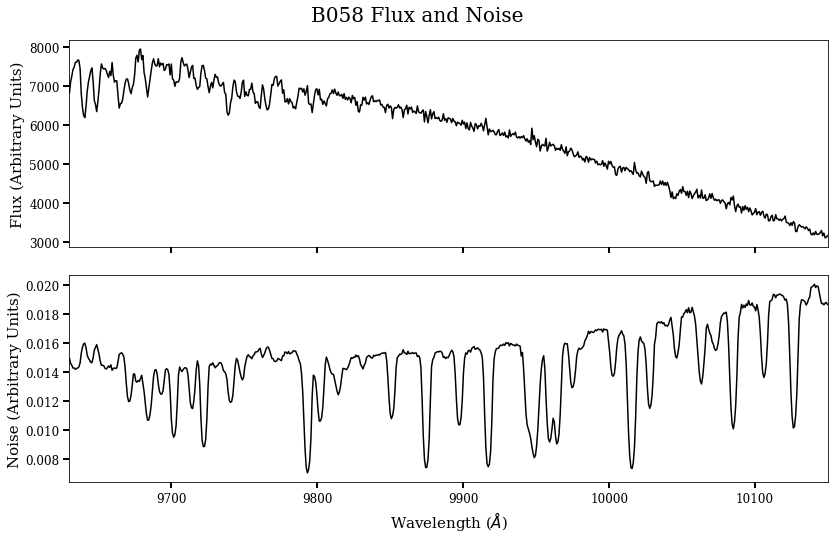

In [5]:
#Plot B058 segment prior to normalization
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
fig.set_tight_layout(True)
fig.suptitle('B058 Flux and Noise', fontsize=20, y=0.95)

#Plot flux
ax[0].plot(B058_red_coadd_wave[(9630 <= B058_red_coadd_wave) & (B058_red_coadd_wave <= 10150)],
        B058_red_coadd_flux[(9630 <= B058_red_coadd_wave) & (B058_red_coadd_wave <= 10150)], color='k')
ax[0].set_ylabel('Flux (Arbitrary Units)', fontsize=15)
ax[0].tick_params(length=6, width=2, labelsize=12)
ax[0].set_xlim(9630, 10150)

#Plot noise
ax[1].plot(B058_red_coadd_wave[(9630 <= B058_red_coadd_wave) & (B058_red_coadd_wave <= 10150)],
        B058_red_coadd_noise[(9630 <= B058_red_coadd_wave) & (B058_red_coadd_wave <= 10150)], color='k')
ax[1].set_xlabel('Wavelength ($\AA$)', fontsize=15)
ax[1].set_ylabel('Noise (Arbitrary Units)', fontsize=15)
ax[1].tick_params(length=6, width=2, labelsize=12)
ax[1].set_xlim(9630, 10150)

And this is what it looks like after normalization:

(9630.0, 10150.0)

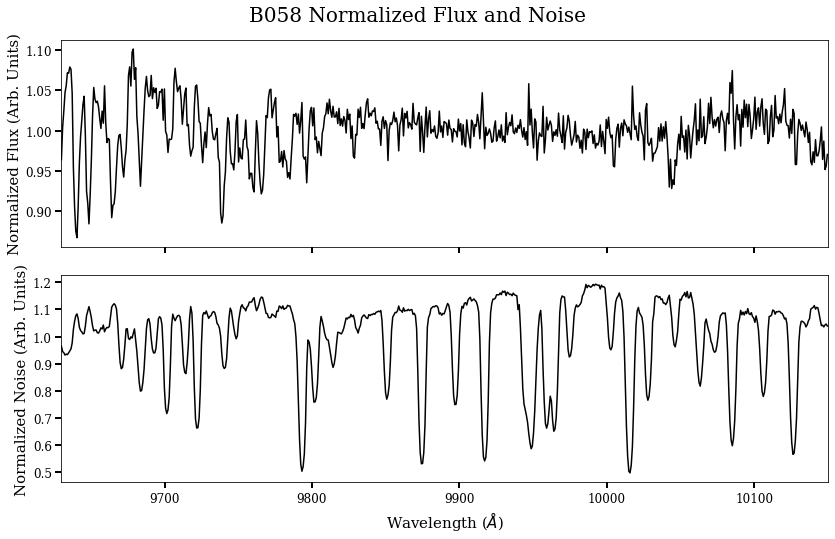

In [6]:
#Plot B058 segment after to normalization
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
fig.set_tight_layout(True)
fig.suptitle('B058 Normalized Flux and Noise', fontsize=20, y=0.95)

#Plot flux
ax[0].plot(B058_norm_wave_example, B058_norm_flux_example, color='k')
ax[0].set_ylabel('Normalized Flux (Arb. Units)', fontsize=15)
ax[0].tick_params(length=6, width=2, labelsize=12)
ax[0].set_xlim(9630, 10150)

#Plot noise
ax[1].plot(B058_norm_wave_example, B058_norm_noise_example, color='k')
ax[1].set_xlabel('Wavelength ($\AA$)', fontsize=15)
ax[1].set_ylabel('Normalized Noise (Arb. Units)', fontsize=15)
ax[1].tick_params(length=6, width=2, labelsize=12)
ax[1].set_xlim(9630, 10150)

We also need some code to calculate the wavelength-dependent resolution of the Keck LRIS instrument, in km/s:

In [7]:
def lris_res(lb, lr):
    """Get wavelength dependent resolution.
    
    Parameters
    ----------
    lb, lr : Arrays of blue and red wavelengths in angstroms in vacuum.
    
    Returns
    -------
    resb, resr : Resolution in km/s
    """
    
    resb = 3.09 + 0.187*(lb - 5000.)/1000. #res in A
    resb = resb/lb*3.e5 #res in km/s
    l9 = (lr - 9000.)/1000.
    resr = 1.26 - 0.128*l9 + 0.168*l9**2 + 0.1173*l9**3
    resr = resr/lr*3.E5
    
    return resb, resr

This is also useful in other contexts.  For example, you can calculate the spectral resolution of the wavelength regions covered by our B058 spectra like this:

Text(0.5, 1.0, 'B058 LRIS Resolution')

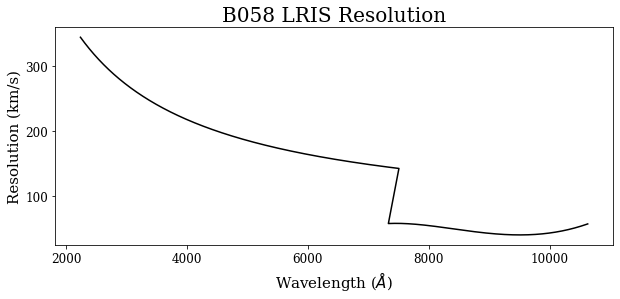

In [8]:
#Calculate B058 LRIS resolution
B058_example_resb, B058_example_resr = lris_res(B058_blue_coadd_wave, B058_red_coadd_wave)

#Plot the wavelength-dependent resolution
plt.figure(figsize=(10,4))
plt.plot(np.concatenate((B058_blue_coadd_wave, B058_red_coadd_wave)), 
         np.concatenate((B058_example_resb, B058_example_resr)), color='k')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Resolution (km/s)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('B058 LRIS Resolution', fontsize=20)

Now we will define some functions that I have modified from the [`specutils`](https://specutils.readthedocs.io/en/stable/index.html) module.  I have PR'd these changes but at the time of writing I'm not sure if they have been merged.  In particular, I have made modifications to the [`template_redshift`](https://specutils.readthedocs.io/en/stable/api/specutils.analysis.template_redshift.html) functions and supporting functions.

In [9]:
############################################
# Re-jigged specutils functions            #
############################################

def _uncertainty_to_standard_deviation(uncertainty):
    """
    Convenience function to convert other uncertainty types to standard deviation,
    for consistency in calculations elsewhere.
    Parameters
    ----------
    uncertainty : :class:`~astropy.nddata.NDUncertainty`
        The input uncertainty
    Returns
    -------
    :class:`~numpy.ndarray`
        The array of standard deviation values.
    """
    if uncertainty is not None:
        if isinstance(uncertainty, StdDevUncertainty):
            stddev = uncertainty.array
        elif isinstance(uncertainty, VarianceUncertainty):
            stddev = np.sqrt(uncertainty.array)
        elif isinstance(uncertainty, InverseVariance):
            stddev = 1 / np.sqrt(uncertainty.array)

        return stddev

def _resample(resample_method):
    """
    Find the user preferred method of resampling the template spectrum to fit
    the observed spectrum.
    Parameters
    ----------
    resample_method: `string`
        The type of resampling to be done on the template spectrum.
    Returns
    -------
    :class:`~specutils.ResamplerBase`
        This is the actual class that will handle the resampling.
    """
    if resample_method == "flux_conserving":
        return FluxConservingResampler()

    if resample_method == "linear_interpolated":
        return LinearInterpolatedResampler()

    if resample_method == "spline_interpolated":
        return SplineInterpolatedResampler()

    return None

def _normalize_for_template_matching(observed_spectrum, template_spectrum, stddev=None):
    """
    Calculate a scale factor to be applied to the template spectrum so the
    total flux in both spectra will be the same.
    Parameters
    ----------
    observed_spectrum : :class:`~specutils.Spectrum1D`
        The observed spectrum.
    template_spectrum : :class:`~specutils.Spectrum1D`
        The template spectrum, which needs to be normalized in order to be
        compared with the observed spectrum.
    Returns
    -------
    `float`
        A float which will normalize the template spectrum's flux so that it
        can be compared to the observed spectrum.
    """
    if stddev is None:
        stddev = _uncertainty_to_standard_deviation(observed_spectrum.uncertainty)
    #Changed to np.nansum
    num = np.nansum((observed_spectrum.flux*template_spectrum.flux) / (stddev**2))
    denom = np.nansum((template_spectrum.flux / stddev)**2)

    return num/denom

def _chi_square_for_templates(observed_spectrum, template_spectrum, resample_method):
    """
    Resample the template spectrum to match the wavelength of the observed
    spectrum. Then, calculate chi2 on the flux of the two spectra.
    Parameters
    ----------
    observed_spectrum : :class:`~specutils.Spectrum1D`
        The observed spectrum.
    template_spectrum : :class:`~specutils.Spectrum1D`
        The template spectrum, which will be resampled to match the wavelength
        of the observed spectrum.
    Returns
    -------
    normalized_template_spectrum : :class:`~specutils.Spectrum1D`
        The normalized spectrum template.
    chi2 : `float`
        The chi2 of the flux of the observed spectrum and the flux of the
        normalized template spectrum.
    """
    # Resample template
    if _resample(resample_method) != 0:
        fluxc_resample = _resample(resample_method)
        template_obswavelength = fluxc_resample(template_spectrum,
                                                observed_spectrum.spectral_axis)

    # Convert the uncertainty to standard deviation if needed
    stddev = _uncertainty_to_standard_deviation(observed_spectrum.uncertainty)

    # Normalize spectra
    normalization = _normalize_for_template_matching(observed_spectrum,
                                                     template_obswavelength,
                                                     stddev)

    # Numerator
    num_right = normalization * template_obswavelength.flux
    num = observed_spectrum.flux - num_right

    # Denominator
    denom = stddev * observed_spectrum.flux.unit

    # Get chi square
    result = (num/denom)**2
    chi2 = np.nansum(result.value) #Changed to np.nansum

    # Create normalized template spectrum, which will be returned with
    # corresponding chi2
    normalized_template_spectrum = Spectrum1D(
        spectral_axis=template_spectrum.spectral_axis,
        flux=template_spectrum.flux*normalization)

    return normalized_template_spectrum, chi2

def template_redshift(observed_spectrum, template_spectrum, redshift):
    """
    Find the best-fit redshift for template_spectrum to match observed_spectrum using chi2.
    Parameters
    ----------
    observed_spectrum : :class:`~specutils.Spectrum1D`
        The observed spectrum.
    template_spectrum : :class:`~specutils.Spectrum1D`
        The template spectrum, which will have it's redshift calculated.
    redshift : `float`, `int`, `list`, `tuple`, 'numpy.array`
        A scalar or iterable with the redshift values to test.
    Returns
    -------
    final_redshift : `float`
        The best-fit redshift for template_spectrum to match the observed_spectrum.
    redshifted_spectrum: :class:`~specutils.Spectrum1D`
        A new Spectrum1D object which incorporates the template_spectrum with a spectral_axis
        that has been redshifted using the final_redshift.
    chi2_list : `list`
        A list with the chi2 values corresponding to each input redshift value.
    """
    chi2_min = None
    final_redshift = None
    chi2_list = []

    redshift = np.array(redshift).reshape((np.array(redshift).size,))

    # Loop which goes through available redshift values and finds the smallest chi2
    for rs in redshift:

        # Create new redshifted spectrum and run it through the chi2 method
        redshifted_spectrum = Spectrum1D(spectral_axis=template_spectrum.spectral_axis*(1+rs),
                        flux=template_spectrum.flux, uncertainty=template_spectrum.uncertainty,
                                         meta=template_spectrum.meta)
        normalized_spectral_template, chi2 = _chi_square_for_templates(observed_spectrum, redshifted_spectrum, 
                                                                       'flux_conserving')

        chi2_list.append(chi2)

        # Set new chi2_min if suitable replacement is found - added line here b/c not returning final redshifted spectrum
        if not np.isnan(chi2) and (chi2_min is None or chi2 < chi2_min):
            chi2_min = chi2
            final_redshift = rs
            final_spectrum = redshifted_spectrum #Added

    return final_redshift, chi2_min, final_spectrum, chi2_list

In general, you can use this to calculate a redshift of a spectrum given a template spectrum at rest.  

*Example here*

### Blue flexure correction
Now we will go through how to do the flexure correction on the blue side.  I'm going to dump a bunch of functions here, and I will go through how to use each of them as well as how to check the quality of your flexure correction below.

In [10]:
#####################################
# Blue flexure correction functions #
#####################################
def smooth_general(lris_resolution, data_resolution, wave, flux, noise):
    """Returns flux and noise smoothed to LRIS resolution.
    
    Parameters
    ----------
    lris_resolution : tuple
        Wavelength-dependent LRIS resolutions
    data_resolution : tuple
        Resolution of the data
    wave : tuple
        Data wavelengths
    flux : tuple
        Data fluxes
    noise : tuple
        Data noise
        
    Returns
    -------
    smoothed_flux : tuple
        Data flux smoothed to LRIS resolution
    smoothed_noise : tuple
        Data noise smoothed to LRIS resolution
    """
    
    c = 299792.458 #speed of light in km/s
    sigma_aa_desired = lris_resolution/c*wave
    sigma_aa_original = data_resolution
    delta_sigma_aa_vector = np.sqrt(sigma_aa_desired**2 - sigma_aa_original**2)
    smoothed_flux = utils.smoothing.smoothspec(wave, flux, outwave=wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, 
                                               fftsmooth=True)
    smoothed_noise = utils.smoothing.smoothspec(wave, noise, outwave=wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, 
                                                fftsmooth=True)
    return smoothed_flux, smoothed_noise

def prep_data(data_path, spec_type):
    """Return the full blue data and the data limited to the relevant wavelength ranges.
    
    Parameters
    ----------
    data_path : str
        Path to the data file (coadd or spec1d)
    spec_type : str
        Indicates if looking at coadded spectrum or single 1D spectrum
        
    Returns
    -------
    data_wave_full : tuple
        Full blue wavelength array
    data_cut_wave : tuple
        Blue wavelength array limited to relevant range
    data_flux_full: tuple
        Full blue flux array
    data_cut_flux : tuple
        Blue flux array limited to relevant range
    data_noise_full : tuple
        Full blue noise array
    data_cut_noise : tuple
        Blue noise array limited to relevant range
    """
    
    #Import co-added spectrum with no flexure correction
    data_file = fits.open(data_path)
    if spec_type == 'coadd':
        data_wave_full = data_file[1].data['wave']
        data_flux_full = data_file[1].data['flux']
        data_noise_full = np.sqrt(data_file[1].data['ivar'])
    else:
        data_wave_full = data_file[1].data['OPT_WAVE']
        data_flux_full = data_file[1].data['OPT_COUNTS']
        data_noise_full = np.sqrt(data_file[1].data['OPT_COUNTS_IVAR'])
    data_file.close()

    #Limit to useful range
    data_cut_wave = data_wave_full[(data_wave_full >= 4000) & (data_wave_full <= 6800)]
    data_cut_flux = data_flux_full[(data_wave_full >= 4000) & (data_wave_full <= 6800)]
    data_cut_noise = data_noise_full[(data_wave_full >= 4000) & (data_wave_full <= 6800)]

    return data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise

def prep_template(template_path):
    """Return the smoothed template data.
    
    Parameters
    ----------
    template_path : str
        Path to template spectrum file
        
    Returns
    -------
    template_wave : tuple
        Template wavelength array
    smoothed_template_flux : tuple
        Smoothed template flux array
    smoothed_template_noise : tuple
        Smoothed template noise array
    """
    
    #Import template
    template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+', 
                                names=['wavelength', 'flux', 'noise', 'weight', 'resolution'], index_col=None)
    template_flux = template_file['flux'].values[(template_file['wavelength'].values >= 4000) & \
                                                 (template_file['wavelength'].values <= 6800)]
    template_wave = template_file['wavelength'].values[(template_file['wavelength'].values >= 4000) & \
                                                       (template_file['wavelength'].values <= 6800)]
    template_noise = np.zeros(len(template_wave))
    template_resolution = template_file['resolution'].values[(template_file['wavelength'].values >= 4000) & \
                                                             (template_file['wavelength'].values <= 6800)]

    #Calculate desired resolution for data template (Keck resolution)
    resb_template, resr_template = lris_res(template_wave, np.nan)

    #Smooth the template 
    smoothed_template_flux, smoothed_template_noise = smooth_general(resb_template, template_resolution, template_wave, 
                                                                     template_flux, template_noise)
    return template_wave, smoothed_template_flux, smoothed_template_noise

def test_pre_full(data_path, template_path, z_lit, z_bound, spec_type):
    """Returns the full spectrum best-fit redshift and min chi2. 
    Tests the redshift array on the entire spectrum to ensure bounds are appropriate.
    
    Parameters
    ----------
    data_path : str
        Path to data spectrum file
    template_path : str
        Path to template spectrum file
    z_lit : float
        Literature redshift for target object
    z_bound : float
        Amount to add and subtract from z_lit for redshifts to test
    spec_type : str
        Indicates if looking at coadded spectrum or single 1D spectrum
        
    Returns
    -------
    tm_result[0] : float
        Best-fit redshift
    tm_result[1] : float
        Minimum chi-squared
    """
    
    #Import data
    data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise = prep_data(data_path, 
                                                                                                              spec_type)

    #Import smoothed template
    template_wave, smoothed_template_flux, smoothed_template_noise = prep_template(template_path)

    #Continuum normalize over whole wavelength range
    norm_data_wave, norm_data_flux, norm_data_noise = continuum_normalize(np.min(data_cut_wave), np.max(data_cut_wave), 
                                                                          data_cut_flux, data_cut_wave, data_cut_noise)
    norm_template_wave, norm_template_flux, norm_template_noise = continuum_normalize(np.min(template_wave), 
                                                                                      np.max(template_wave),
                                                                                      smoothed_template_flux, template_wave, 
                                                                                      smoothed_template_noise)

    #Put spectra into Spectrum1D objects
    data_spec = Spectrum1D(spectral_axis=norm_data_wave*u.Angstrom, flux=norm_data_flux*(u.erg/u.s/u.cm**2/u.Angstrom),
                           uncertainty=StdDevUncertainty(norm_data_noise))
    template_spec = Spectrum1D(spectral_axis=norm_template_wave*u.Angstrom, flux=norm_template_flux*(u.Lsun/u.micron))

    #Plot before
    plt.figure(figsize=(12,4))
    plt.plot(data_spec.spectral_axis, data_spec.flux, label='observed')
    plt.plot(template_spec.spectral_axis, template_spec.flux, label='template')
    plt.legend()
    plt.show()

    #Fit redshifts
    redshifts = np.linspace(z_lit-z_bound, z_lit+z_bound, 1000)
    tm_result = template_redshift(observed_spectrum=data_spec, template_spectrum=template_spec, redshift=redshifts)

    #Plot after
    plt.figure(figsize=(12,4))
    plt.plot(data_spec.spectral_axis, data_spec.flux, label='observed')
    plt.plot(tm_result[2].spectral_axis, tm_result[2].flux, label='redshifted template')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(template_spec.spectral_axis, template_spec.flux, label='template')
    plt.plot(tm_result[2].spectral_axis, tm_result[2].flux, label='redshifted template')
    plt.legend()
    plt.show()
    return tm_result[0], tm_result[1]

def data_chunks(data_wave, data_flux, data_noise, targ_delta):
    """Returns normalized data spectral chunks.
    
    Parameters
    ----------
    data_wave : tuple
        Data wavelength array
    data_flux : tuple
        Data flux array
    data_noise : tuple
        Data noise array
    targ_delta : float
        Size of chunk in Angstroms
        
    Returns
    -------
    norm_wave_chunks : tuple
        Wavelength chunks of size targ_delta
    norm_flux_chunks : tuple
        Normalized flux chunks of size targ_delta
    norm_noise_chunks : tuple
        Normalized noise chunks of size targ_delta
    """
    
    #Chunk data
    #Turn arrays into lists
    wave_arr = list(data_wave)
    flux_arr = list(data_flux)
    noise_arr = list(data_noise)

    wave_chunks = []
    flux_chunks = []
    noise_chunks = []

    #Initialize counters
    i = wave_arr[0]
    k = 0
    for elem in wave_arr:
        elem_delta = elem - i
        if elem_delta >= targ_delta: #If difference is targ_delta
            end_ind = wave_arr.index(elem) + 1 #Find ending index
            wave_chunks.append(np.array(wave_arr[k:end_ind])) #Append appropriate values
            flux_chunks.append(np.array(flux_arr[k:end_ind]))
            noise_chunks.append(np.array(noise_arr[k:end_ind]))

            #Re-initialize counters
            i = wave_arr[end_ind]
            k = end_ind
    else: #Get the end of the arrays that won't be 220A wide
        wave_chunks.append(np.array(wave_arr[k:]))
        flux_chunks.append(np.array(flux_arr[k:]))
        noise_chunks.append(np.array(noise_arr[k:]))

    #Normalize chunks
    normed_data = []
    norm_wave_chunks = []
    norm_flux_chunks = []
    norm_noise_chunks = []
    for i in range(len(wave_chunks)):
        normed_data.append(continuum_normalize(np.min(wave_chunks[i]), np.max(wave_chunks[i]), flux_chunks[i], wave_chunks[i], 
                                               noise_chunks[i]))
        norm_wave_chunks.append(normed_data[i][0])
        norm_flux_chunks.append(normed_data[i][1])
        norm_noise_chunks.append(normed_data[i][2])

    return norm_wave_chunks, norm_flux_chunks, norm_noise_chunks

def template_chunks(data_wave, data_flux, data_noise, template_path, z_lit, targ_delta, overhang, position):
    """Returns normalized template spectral chunks and central wavelengths.
    
    Parameters
    ----------
    data_wave : tuple
        Data wavelength array
    data_flux : tuple
        Data flux array
    data_noise : tuple
        Data noise array
    template_path : str
        Path to template spectrum file
    z_lit : float
        Literature redshift for target object
    targ_delta : float
        Size of chunk in Angstroms
    overhang : float
        Size of overhang that template chunk should have compared to target
    position : str
        'before' or 'after' to indicate if this is pre- or post-flexure correction
        
    Returns
    -------
    norm_temp_wave_chunks : tuple
        Wavelength chunks of size targ_delta
    norm_temp_flux_chunks : tuple
        Normalized flux chunks of size targ_delta
    norm_temp_noise_chunks : tuple
        Normalized noise chunks of size targ_delta
    temp_central_wavelengths : tuple
        Central wavelength in each template chunk
    central_wavelengths : tuple
        Central wavelength in each data chunk
    """
    
    #Import smoothed template
    template_wave, smoothed_template_flux, smoothed_template_noise = prep_template(template_path)

    #Get data chunks
    data_wave_chunks, data_flux_chunks, data_noise_chunks = data_chunks(data_wave, data_flux, data_noise, targ_delta)

    #Chunk template
    #Find the central wavelength in each bin
    central_wavelengths = np.zeros(len(data_wave_chunks))
    for i in range(len(data_wave_chunks)):
        central_wavelengths[i] = np.median(data_wave_chunks[i])

    if position == 'before':
        dered_central_wavelengths = central_wavelengths/(1+z_lit)
    else:
        dered_central_wavelengths = central_wavelengths

    #Get the bounds of the template chunks (with overhang)
    template_wave_bounds = []
    for i in range(len(data_wave_chunks)):
        template_wave_bounds.append([dered_central_wavelengths[i] - (np.max(data_wave_chunks[i]) - \
                                                               np.min(data_wave_chunks[i]))/2  - overhang, 
                                     dered_central_wavelengths[i] + (np.max(data_wave_chunks[i]) - \
                                                               np.min(data_wave_chunks[i]))/2 + overhang])

    #Chunk the template based on these bounds
    template_wave_chunks = []
    template_flux_chunks = []
    template_noise_chunks = []
    for i in range(len(template_wave_bounds)):
        template_wave_chunks.append(template_wave[(template_wave >= template_wave_bounds[i][0]) & \
                                                  (template_wave <= template_wave_bounds[i][-1])])
        template_flux_chunks.append(smoothed_template_flux[(template_wave >= template_wave_bounds[i][0]) & \
                                                  (template_wave <= template_wave_bounds[i][-1])])
        template_noise_chunks.append(np.zeros(len(template_wave_chunks[i])))

    #Normalize the template chunks
    normed_template_data = []
    norm_temp_wave_chunks = []
    norm_temp_flux_chunks = []
    norm_temp_noise_chunks = []
    for i in range(len(template_wave_chunks)):
        normed_template_data.append(continuum_normalize(np.min(template_wave_chunks[i]), np.max(template_wave_chunks[i]), 
                                                        template_flux_chunks[i], template_wave_chunks[i], 
                                                        template_noise_chunks[i]))
        norm_temp_wave_chunks.append(normed_template_data[i][0])
        norm_temp_flux_chunks.append(normed_template_data[i][1])
        norm_temp_noise_chunks.append(normed_template_data[i][2])

    #Get centre of each template chunk and redshift it
    temp_central_wavelengths = np.zeros(len(norm_temp_wave_chunks))
    for i in range(len(norm_temp_wave_chunks)):
        temp_central_wavelengths[i] = np.median(norm_temp_wave_chunks[i])*(1+z_lit)

    return norm_temp_wave_chunks, norm_temp_flux_chunks, norm_temp_noise_chunks, temp_central_wavelengths, central_wavelengths

def QA_chunks(data_wave_chunks, data_flux_chunks, temp_wave_chunks, temp_flux_chunks):
    """Plots the data and template chunks against each other to make sure they look okay.
    
    Parameters
    ----------
    data_wave_chunks : tuple
        Data wavelength chunks of size targ_delta
    data_flux_chunks : tuple
        Normalized data flux chunks of size targ_delta
    temp_wave_chunks : tuple
        Template wavelength chunks of size targ_delta +- overhang
    temp_flux_chunks : tuple
        Normalized template flux chunks of size targ_delta +- overhang 
        
    Returns
    -------
    None
    """
    
    #Plot
    for i in range(len(data_wave_chunks)):
        plt.figure()
        plt.plot(data_wave_chunks[i], data_flux_chunks[i], label='observed')
        plt.plot(temp_wave_chunks[i], temp_flux_chunks[i], label='template')
        plt.legend()

def chunk_redshift(data_wave, data_flux, data_noise, template_path, z_lit, targ_delta, overhang, z_test, z_bound, position):
    """Returns the bestfit redshift of each chunk.
    
    Parameters
    ----------
    data_wave : tuple
        Data wavelength array
    data_flux : tuple
        Data flux array
    data_noise : tuple
        Data noise array
    template_path : str
        Path to template spectrum file
    z_lit : float
        Literature redshift of target object
    targ_delta : float
        Wavelength chunk size in Angstroms
    overhang : float
        Amount of wavelength overhang template chunks should have in Angstroms
    z_test : float
        Starting redshift for chunks (measured by eye in 1 chunk)
    z_bound : float
        Amount to add and subtract from z_lit for redshifts to test
    position : str
        'before' or 'after' to indicate if pre- or post-flexure correction
        
    Results
    -------
    bestfit_redshift : tuple
        Best fitting redshift for each chunk
    best_chi2 : tuple
        Minimum chi squared for each chunk
    redshifted_spectra : tuple
        Redshifted chunks
    chi2 : tuple
        All chi2
    """
    
    #Get data chunks
    data_wave_chunks, data_flux_chunks, data_noise_chunks = data_chunks(data_wave, data_flux, data_noise, targ_delta)

    #Get template_chunks 
    temp_wave_chunks, temp_flux_chunks, temp_noise_chunks, temp_central_wavelengths, central_waves = template_chunks(data_wave, 
                                                                                                                     data_flux,
                                                                                                      data_noise, template_path,
                                                                                                      z_lit, targ_delta,
                                                                                                      overhang, position)

    #Find redshifts of each chunk
    observed_chunks = []
    temp_chunks = []
    for i in range(len(data_wave_chunks)):
        observed_chunks.append(Spectrum1D(spectral_axis=data_wave_chunks[i]*u.Angstrom, 
                                          flux=data_flux_chunks[i]*(u.erg/u.s/u.cm**2/u.Angstrom), 
                                          uncertainty=InverseVariance(data_noise_chunks[i])))
        temp_chunks.append(Spectrum1D(spectral_axis=temp_wave_chunks[i]*u.Angstrom, 
                                 flux=temp_flux_chunks[i]*(u.Lsun/u.micron),
                                 uncertainty=StdDevUncertainty(temp_noise_chunks[i])))

    redshifts_chunks = np.linspace(z_test-z_bound, z_test+z_bound, 1000)
    fitted_redshift_results = []
    bestfit_redshift = np.zeros(len(data_wave_chunks))
    best_chi2 = np.zeros(len(data_wave_chunks))
    redshifted_spectra = []
    chi2 = []
    for i in range(len(data_wave_chunks)):
        fitted_redshift_results.append(template_redshift(observed_spectrum=observed_chunks[i], 
                                                            template_spectrum=temp_chunks[i],
                                                            redshift=redshifts_chunks))
        bestfit_redshift[i] = fitted_redshift_results[i][0]
        best_chi2[i] = fitted_redshift_results[i][1]
        redshifted_spectra.append(fitted_redshift_results[i][2])
        chi2.append(fitted_redshift_results[i][3])
        
    return bestfit_redshift, best_chi2, redshifted_spectra, chi2

def fit_errors(bestfit_redshift, central_wavelengths):
    """Returns the fits to be used to correct the flexure
    
    Parameters
    ----------
    bestfit_redshift : tuple
        Best fitting redshift in each wavelength chunk
    central_wavelengths : tuple
        Central wavelength of each chunk
        
    Returns
    -------
    fit : np.polyfit object
        Straight line fit to errors in Angstroms
    fit_z : np.polyfit object
        Straight line fit to errors in redshift
    fit_kms : np.polyfit object
        Straight line fit to errors in km/s
    error_func : np.poly1d object
        Straight line fit function to errors in Angstroms
    error_func_z : np.poly1d object
        Straight line fit function to errors in redshift
    error_func_kms : np.poly1d object
        Straight line fit function to errors in km/s
    errors_A : tuple
        Flexure in Angstroms
    """
    
    c = 299792.458 #speed of light in km/s
    #Calculate errors in Angstroms
    errors_A = bestfit_redshift*central_wavelengths 

    #Fit a straight line to the errors
    fit = np.polyfit(central_wavelengths, errors_A, 1)
    fit_z = np.polyfit(central_wavelengths, bestfit_redshift, 1)
    fit_kms = np.polyfit(central_wavelengths, errors_A/central_wavelengths*c, 1)

    error_func = np.poly1d(fit)
    error_func_z = np.poly1d(fit_z)
    error_func_kms = np.poly1d(fit_kms)
    
    return fit, fit_z, fit_kms, error_func, error_func_z, error_func_kms, errors_A

def QA_fit(bestfit_redshift, central_wavelengths):
    """Plots the errors and fits to check the fit visually.
    
    Parameters
    ----------
    bestfit_redshift : tuple
        Best fitting redshift in each wavelength chunk
    central_wavelengths : tuple
        Central wavelength of each chunk
    
    Returns
    -------
    None
    """
    
    fit, fit_z, fit_kms, error_func, error_func_z, error_func_kms, errors_A = fit_errors(bestfit_redshift, central_wavelengths)

    c = 299792.458 #speed of light in km/s
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.set_tight_layout(True)
    #Plot in z
    ax[0].plot(central_wavelengths, bestfit_redshift, linestyle='None', marker='.', markersize=30, mew=2, mec='w', color='k',
               alpha=0.8)
    ax[0].plot(central_wavelengths, error_func_z(central_wavelengths), color='k')
    ax[0].tick_params(length=6, width=2, labelsize=12)
    ax[0].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[0].set_ylabel('Error (z)', fontsize=15)

    #Plot in Angstroms
    ax[1].plot(central_wavelengths, errors_A, linestyle='None', marker='.', markersize=30, mew=2, mec='w', color='k', alpha=0.8)
    ax[1].plot(central_wavelengths, error_func(central_wavelengths), color='k')
    ax[1].tick_params(length=6, width=2, labelsize=12)
    ax[1].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[1].set_ylabel('Error ($\Delta\AA$)', fontsize=15)

    #Plot in km/s
    ax[2].plot(central_wavelengths, errors_A/central_wavelengths*c, linestyle='None', marker='.', markersize=30, mew=2, mec='w',
               color='k', alpha=0.8)
    ax[2].plot(central_wavelengths, error_func_kms(central_wavelengths), color='k')
    ax[2].tick_params(length=6, width=2, labelsize=12)
    ax[2].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[2].set_ylabel('Error ($\Delta$ km/s)', fontsize=15)

def flexure_function(fit, z_lit, wave):
    """Returns flexure-corrected wavelengths.
    
    Parameters
    ----------
    fit : np.polyfit object
        Straight line fit to errors in Angstroms
    z_lit : float
        Literature redshift of target object
    wave : tuple
        Data wavelength array
    
    Returns
    -------
    corr_factor : tuple
        Amount by which to correct the wavelength array
    wave_corr : tuple
        Flexure-corrected wavelength array
    """
    
    #Solve coefficients
    c = fit[0]
    d = fit[1]

    a = d
    b = (c - z_lit)/(1+z_lit)

    corr_factor = (b*wave + a)/(1 + b)
    wave_corr = wave - corr_factor

    #Check if monotonic
    print('Montonic: ', np.all(np.diff(wave_corr) > 0))
    
    return corr_factor, wave_corr

def flexure_QA(wave, wave_corr):
    """Plots the corrected wavelength against the uncorrected to check quality of correction.
    
    Parameters
    ----------
    wave : tuple
        Uncorrected wavelength array
    wave_corr : tuple
        Flexure-corrected wavelength array
        
    Returns
    -------
    None
    """
    
    plt.figure(figsize=(8,7))
    plt.plot(wave, label='original', lw=3)
    plt.plot(wave_corr, label='corrected', linestyle='dashed')
    plt.legend()
    plt.ylabel('Wavelength ($\AA$)')
    plt.xlabel('Pixel')

def dered_corr(data_path, template_path, wave_corr, z_lit, z_bound, spec_type):
    """Function to check remaining flexure after flexure correction has been applied.
    
    Parameters
    ----------
    data_path : str
        Path to data spectrum file
    template_path : str
        Path to template spectrum file
    wave_corr : tuple
        Flexure-corrected wavelength array
    z_lit : float
        Literature redshift for target object
    z_bound : float
        Amount to add and subtract from z_lit for redshifts to test
    spec_type : str
        Indicates if looking at coadded spectrum or single 1D spectrum
        
    Returns
    -------
    tm_result_corr : float
        Best-fitting redshift post flexure-correction
    dered_wave : tuple
        De-redshifted wavelength array
    """
    
    #Get data
    data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise = prep_data(data_path,
                                                                                                             spec_type)

    #Get template
    template_wave, smoothed_template_flux, smoothed_template_noise = prep_template(template_path)

    #Find redshift of new, corrected spectrum and de-redshift it to match the template
    #Continuum-norm over whole blue range
    norm_wave_corr, norm_corr_flux, norm_corr_noise = continuum_normalize(np.min(wave_corr), np.max(wave_corr), data_cut_flux, 
                                                                          wave_corr, data_cut_noise)
    norm_template_wave, norm_template_flux, norm_template_noise = continuum_normalize(np.min(template_wave), 
                                                                                      np.max(template_wave), 
                                                                                      smoothed_template_flux, template_wave, 
                                                                                      smoothed_template_noise)

    #Plot before
    plt.figure(figsize=(12,4))
    plt.plot(norm_wave_corr, norm_corr_flux, label='observed')
    plt.plot(norm_template_wave, norm_template_flux, label='template')
    plt.legend()

    #Find new redshift of whole spectrum
    corr_spec = Spectrum1D(spectral_axis=norm_wave_corr*u.Angstrom, flux=norm_corr_flux*(u.erg/u.s/u.cm**2/u.Angstrom),
                           uncertainty=StdDevUncertainty(norm_corr_noise))
    template_spec = Spectrum1D(spectral_axis=norm_template_wave*u.Angstrom, flux=norm_template_flux*(u.Lsun/u.micron))

    pre_redshifts = np.linspace(z_lit-z_bound, z_lit+z_bound, 1000)
    tm_result_corr = template_redshift(observed_spectrum=corr_spec, template_spectrum=template_spec, redshift=pre_redshifts)

    #Plot after
    plt.figure(figsize=(12,4))
    plt.plot(corr_spec.spectral_axis, corr_spec.flux, label='observed')
    plt.plot(tm_result_corr[2].spectral_axis, tm_result_corr[2].flux, label='redshifted template')
    plt.legend()

    plt.figure(figsize=(12,4))
    plt.plot(template_spec.spectral_axis, template_spec.flux, label='template')
    plt.plot(tm_result_corr[2].spectral_axis, tm_result_corr[2].flux, label='redshifted template')
    plt.legend()

    #De-redshift data
    dered_wave = norm_wave_corr/(1+z_lit)

    plt.figure(figsize=(12,4))
    plt.plot(dered_wave, norm_corr_flux, label='de-redshifted data')
    plt.plot(norm_template_wave, norm_template_flux, label='template')
    plt.legend()
    
    return tm_result_corr, dered_wave

This next bit follows my [`flexure_example.py`](https://github.com/chloe-mt-cheng/imf_css/blob/main/flexure_example.py) file, but I will add more details and instructions here.  First, we will test finding the redshift of the entire spectrum, just as a sanity check.  This code will output a plot of the template spectrum on top of your data prior to redshifting, the same plot post redshifting, a plot of the redshifted template on top of the original template, and the best-fit redshift and corresponding minimum $\chi^2$ value.  This best-fit redshift will not be consistent with the literature value of the redshift because the data has not been fully flexure corrected yet.

*Need to talk about producing template spectrum*

<ipython-input-10-97df5e3bf8ab>:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+',
<ipython-input-10-97df5e3bf8ab>:153: RankWarning: Polyfit may be poorly conditioned
  norm_data_wave, norm_data_flux, norm_data_noise = continuum_normalize(np.min(data_cut_wave), np.max(data_cut_wave),
<ipython-input-10-97df5e3bf8ab>:153: RankWarning: Polyfit may be poorly conditioned
  norm_data_wave, norm_data_flux, norm_data_noise = continuum_normalize(np.min(data_cut_wave), np.max(data_cut_wave),
<ipython-input-10-97df5e3bf8ab>:155: RankWarning: Polyfit may be poorly conditioned
  norm_template_wave, norm_template_flux, norm_template_noise = continuum_normalize(np.min(template_wave),
<ipython-input-10-97df5e3bf8ab>:155: RankWarning: Polyfit

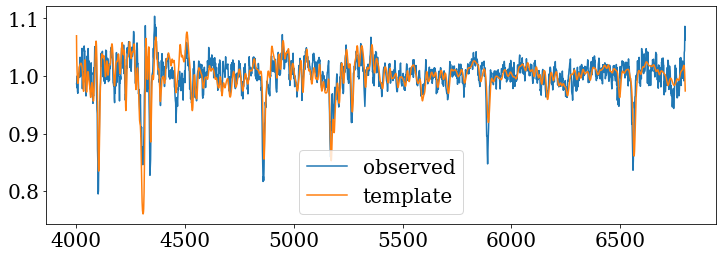

/Applications/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


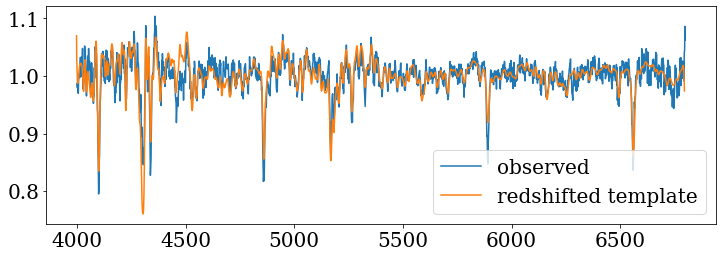

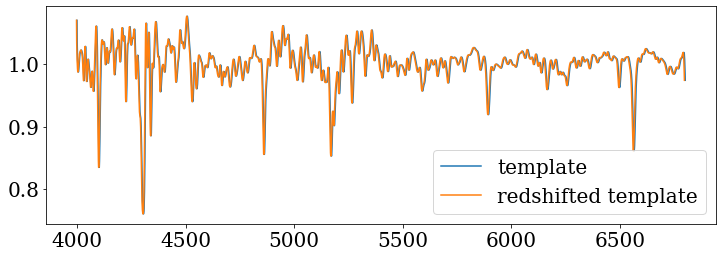

-0.0005558148148148154 0.6393154206870182


In [11]:
#Test with B058
flex_path = 'B058_blue_coadd1d.fits' #Coadded spectrum with PypeIt flexure correction
template_path = 'mock_b058_template.dat' #Template spectrum with B058 age, metallicity

#Test finding redshift of entire spectrum
test_z, test_chi = test_pre_full(flex_path, template_path, -0.000741, 0.005, 'coadd')
print(test_z, test_chi)

Now we will prepare the data (without PypeIt flexure correction) for fitting the redshift in chunks.  **This is where we flexure correct the data**.  First we will read in the data using the function `prep_data`.  Then we will separate it into chunks of 250 Å and continuum-normalize these chunks using the continuum normalization code from above, via the function `data_chunks`.

In [12]:
#Prepare the data for flexure correction by chunking it
noflex_path = 'B058_blue_noflex_coadd1d.fits'
data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise = prep_data(noflex_path, 
                                                                                                         'coadd')
norm_blue_wave_chunks, norm_blue_flux_chunks, norm_blue_noise_chunks = data_chunks(data_cut_wave, data_cut_flux, data_cut_noise,
                                                                                   250)

We will do the same chunking and normalization procedure for the template spectrum, which we already read in during our test, using the function `template_chunks`:

In [13]:
#Chunk and normalize the template
norm_template_wave_chunks, norm_template_flux_chunks, norm_template_noise_chunks, template_central_wavelengths, \
central_wavelengths = template_chunks(data_cut_wave, data_cut_flux, data_cut_noise, template_path, -0.000741, 
                                      250, 20, 'before')

<ipython-input-10-97df5e3bf8ab>:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+',
<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)


Now let's check the data and template chunks to see if they look reasonable.  You want to make sure that the major spectral features in each spectrum are present within the same wavelength chunk, so that the code will be able to find these features to calculate the redshift of the chunk later.

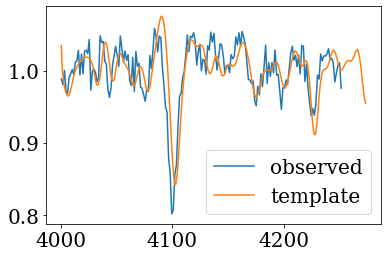

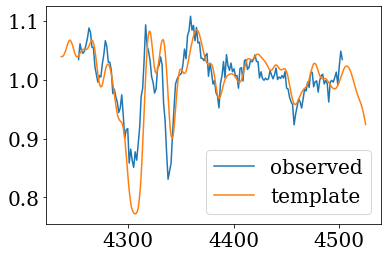

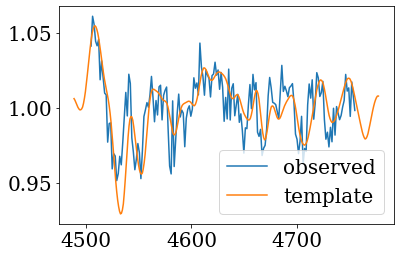

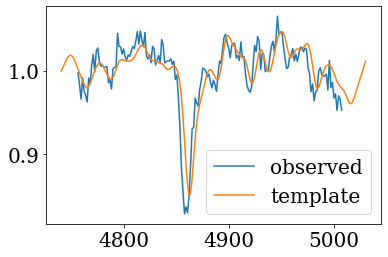

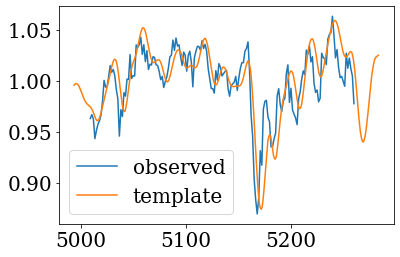

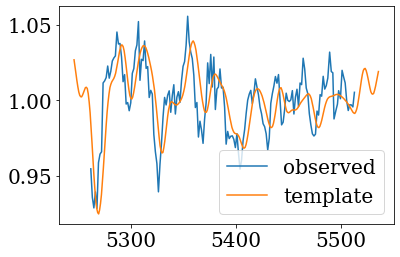

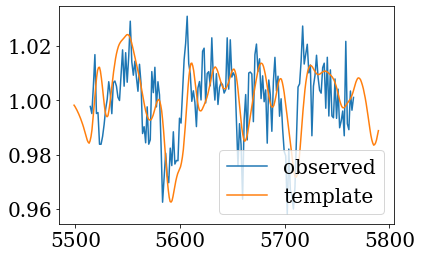

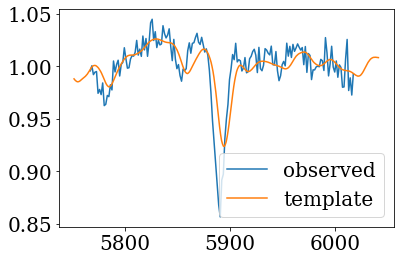

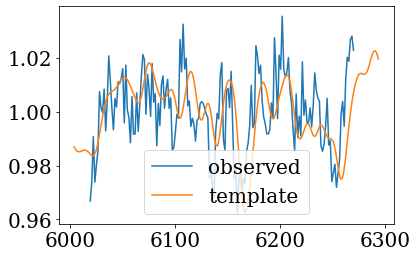

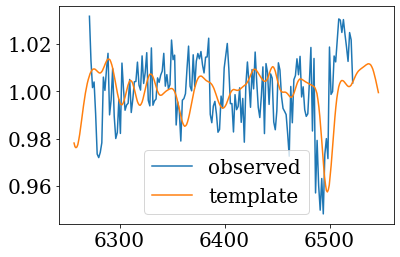

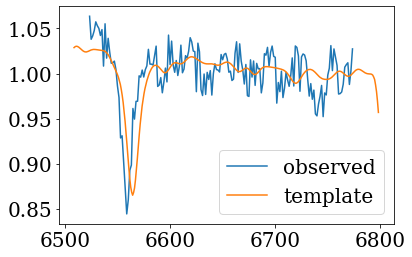

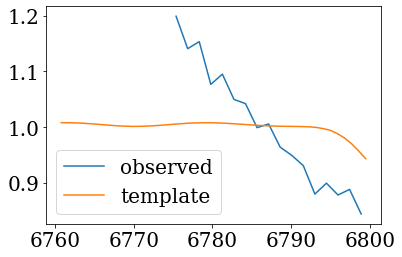

In [14]:
#Plot the chunks to see what they look like
QA_chunks(norm_blue_wave_chunks, norm_blue_flux_chunks, norm_template_wave_chunks, norm_template_flux_chunks)

Then we can go ahead and calculate the redshift in each chunk.  This may take a little while to run.

In [15]:
#Measure the best fitting redshift of each chunk
bestfit_redshift, best_chi2, redshifted_spectra, chi2 = chunk_redshift(data_cut_wave, data_cut_flux, 
                                                                       data_cut_noise, template_path, -0.000741, 
                                                                       250, 20, -0.001828, 0.005, 'after')

<ipython-input-10-97df5e3bf8ab>:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+',
<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)
/Applications/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


We'll just store the redshifted spectra into lists so that we can compare the chunks after redshifting has been done.  You should see that the template and the data match up nearly perfectly now (i.e. orange and blue lines should lie on top of each other).

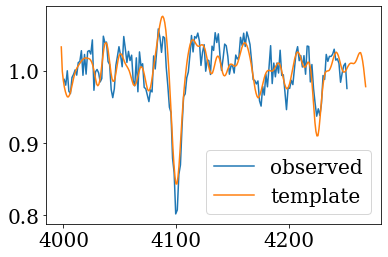

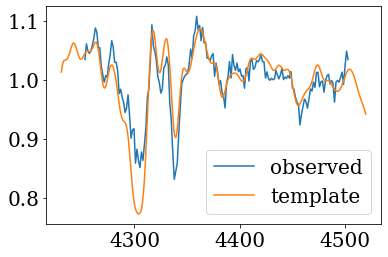

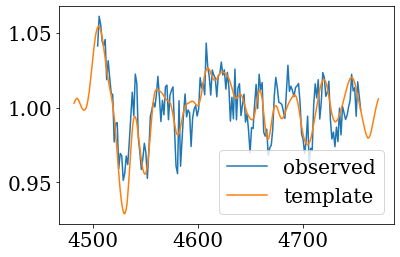

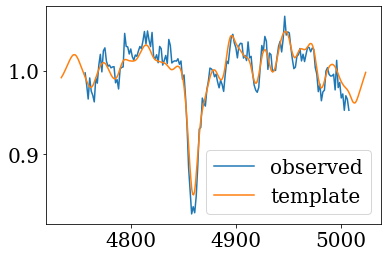

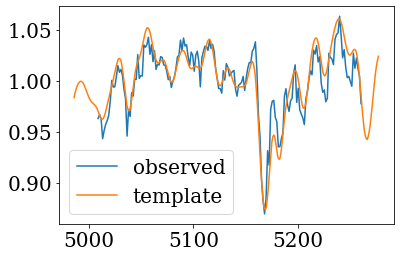

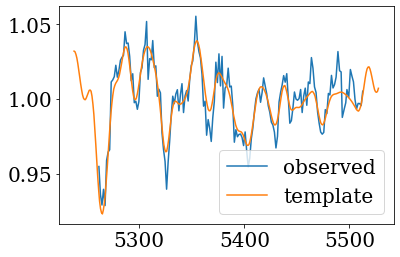

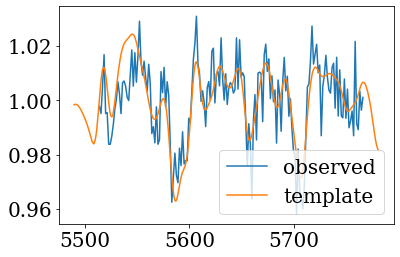

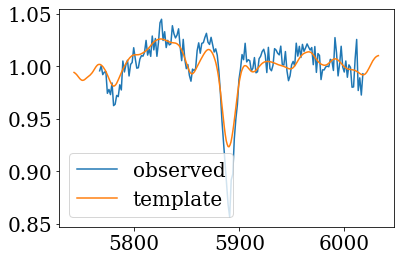

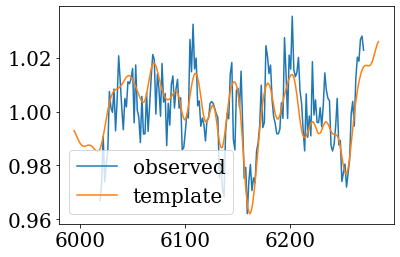

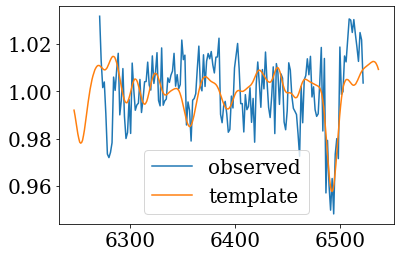

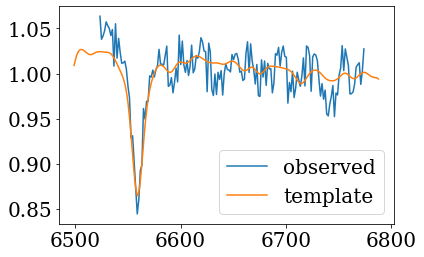

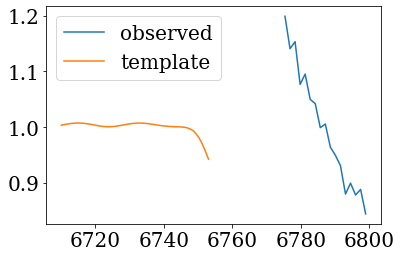

In [16]:
#Check redshifting in chunks
redshifted_waves = []
redshifted_fluxes = []
for i in range(len(redshifted_spectra)):
    redshifted_waves.append(redshifted_spectra[i].spectral_axis)
    redshifted_fluxes.append(redshifted_spectra[i].flux)
QA_chunks(norm_blue_wave_chunks, norm_blue_flux_chunks, redshifted_waves, redshifted_fluxes)

We will now obtain the actual flexure correction function, by plotting the redshift in each chunk and fitting a straight line to it, and then computing the flexure coefficients:

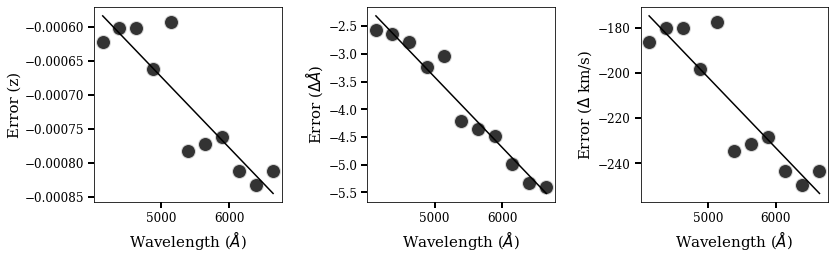

In [17]:
#Calculate flexure correction function
QA_fit(bestfit_redshift[:-1], template_central_wavelengths[:-1])
fit, fit_z, fit_kms, error_func, error_func_z, error_func_kms, errors_A = fit_errors(bestfit_redshift[:-1], 
                                                                                     template_central_wavelengths\
                                                                                     [:-1])

Finally, we can flexure-correct our wavelength array, and check to make sure it is still a monotonic function:

Montonic:  True


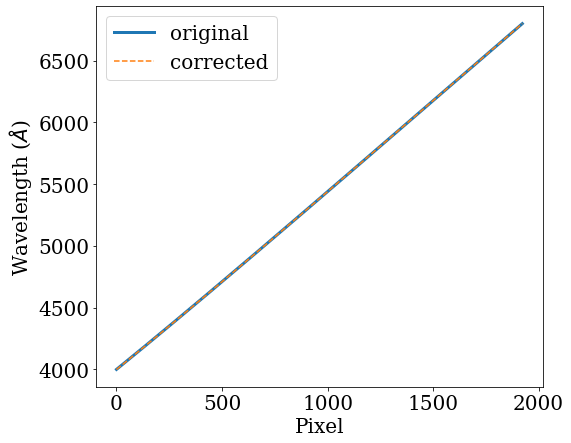

In [18]:
#Flexure correct the wavelength array and check to make sure this is a monotonic function
corr_factor, wave_corr = flexure_function(fit, -0.000741, data_cut_wave)
flexure_QA(data_cut_wave, wave_corr)

To check that our flexure correction worked, we can run all of the same functions that we just ran with the new, flexure-corrected wavelength array.  In essence, what you should see in the final set of `QA_fit` plots is a straight, constant line with random scatter.

<ipython-input-10-97df5e3bf8ab>:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+',
<ipython-input-10-97df5e3bf8ab>:629: RankWarning: Polyfit may be poorly conditioned
  norm_wave_corr, norm_corr_flux, norm_corr_noise = continuum_normalize(np.min(wave_corr), np.max(wave_corr), data_cut_flux,
<ipython-input-10-97df5e3bf8ab>:629: RankWarning: Polyfit may be poorly conditioned
  norm_wave_corr, norm_corr_flux, norm_corr_noise = continuum_normalize(np.min(wave_corr), np.max(wave_corr), data_cut_flux,
<ipython-input-10-97df5e3bf8ab>:631: RankWarning: Polyfit may be poorly conditioned
  norm_template_wave, norm_template_flux, norm_template_noise = continuum_normalize(np.min(template_wave),
<ipython-input-10-97df5e3bf8ab>:631: RankWa

-0.0007259849849849858


<ipython-input-10-97df5e3bf8ab>:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+',
<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)
<ipython-input-10-97df5e3bf8ab>:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+',
<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)
/Applications/an

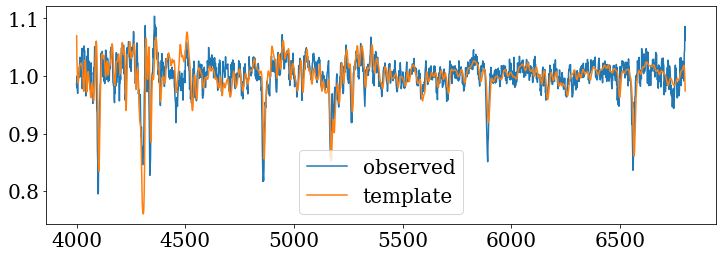

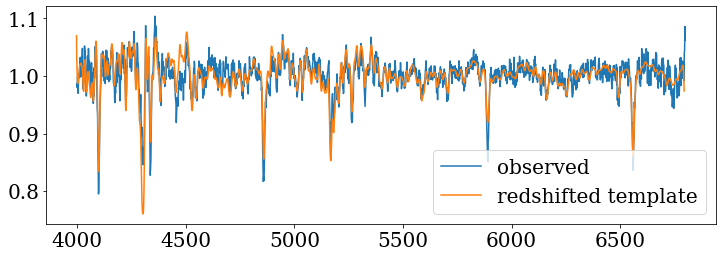

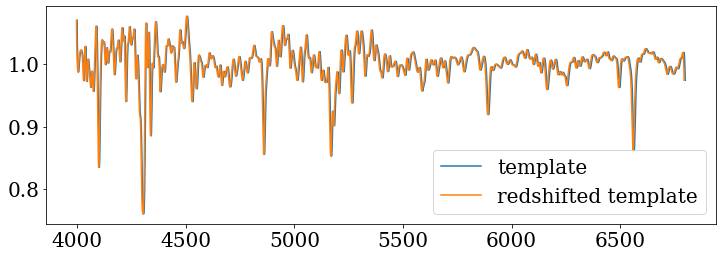

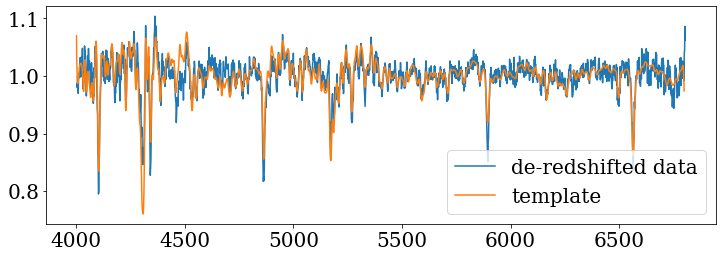

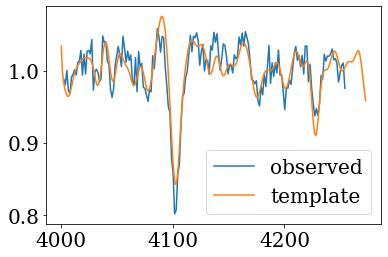

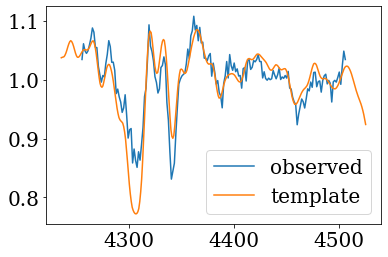

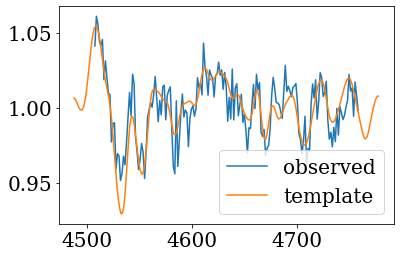

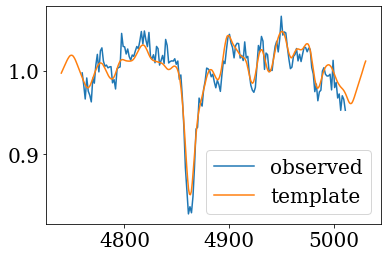

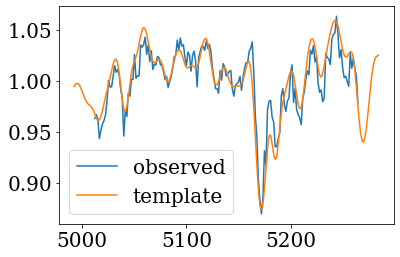

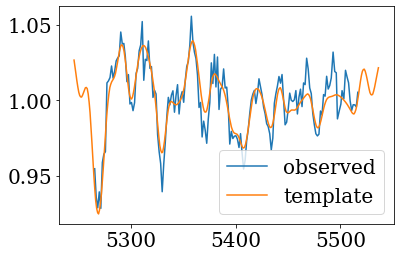

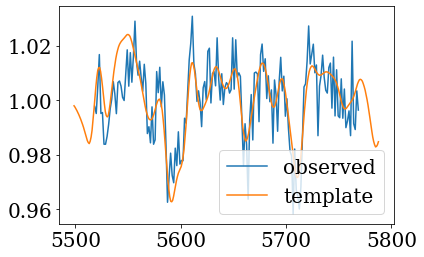

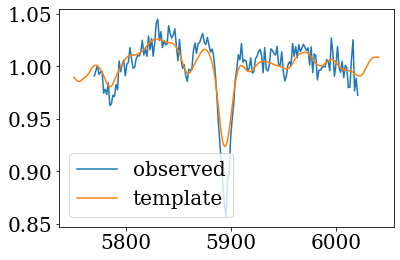

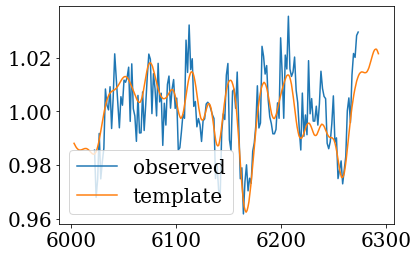

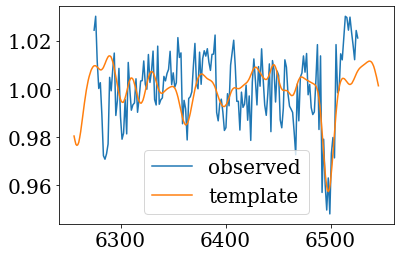

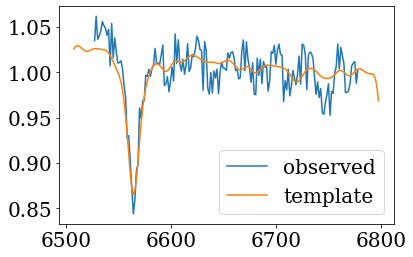

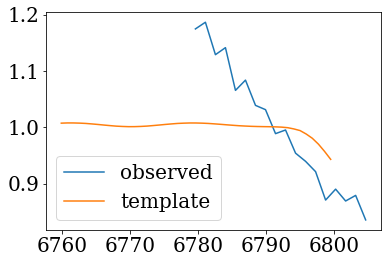

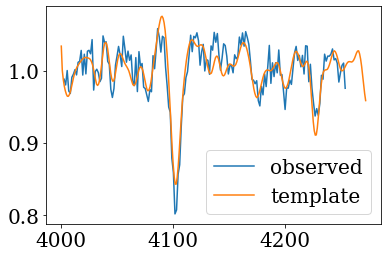

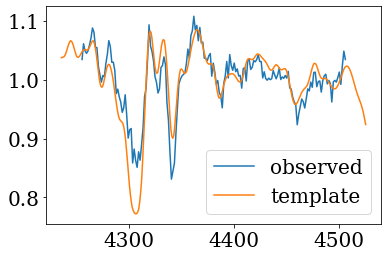

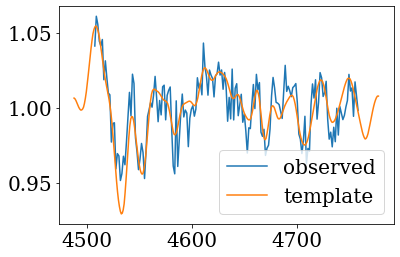

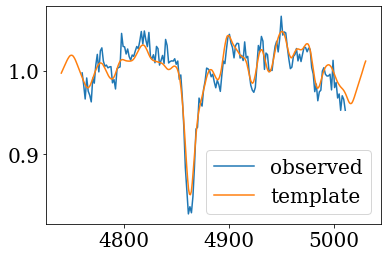

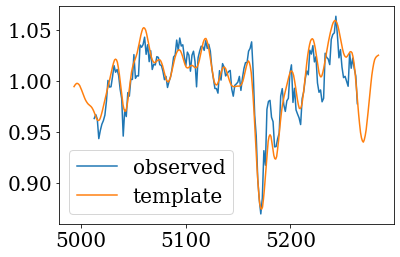

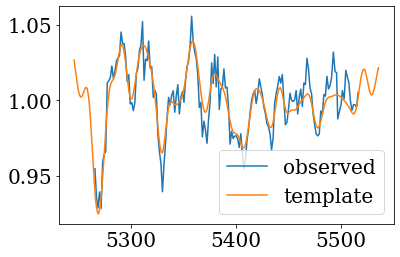

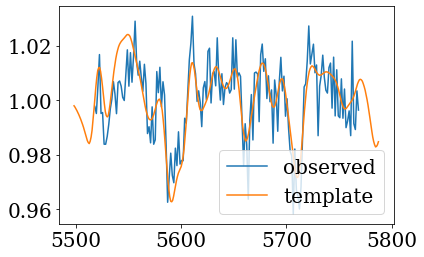

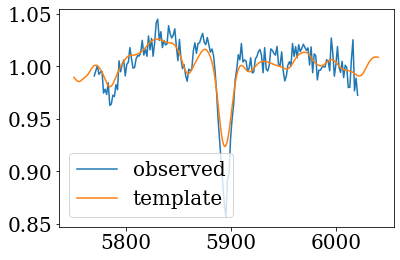

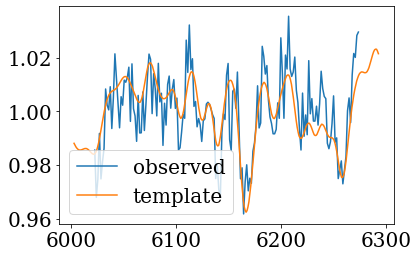

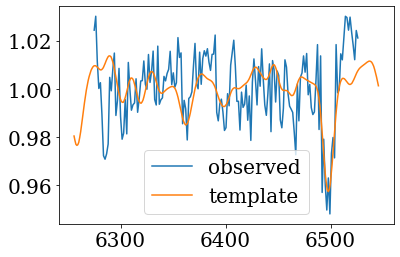

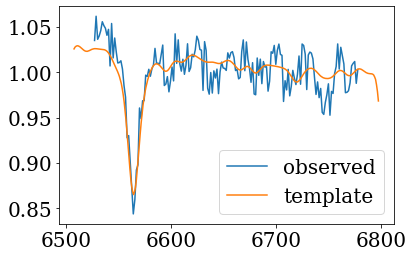

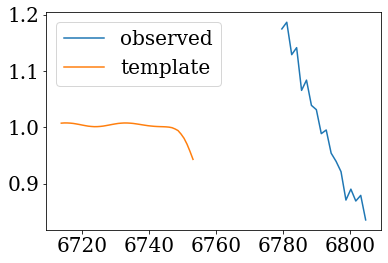

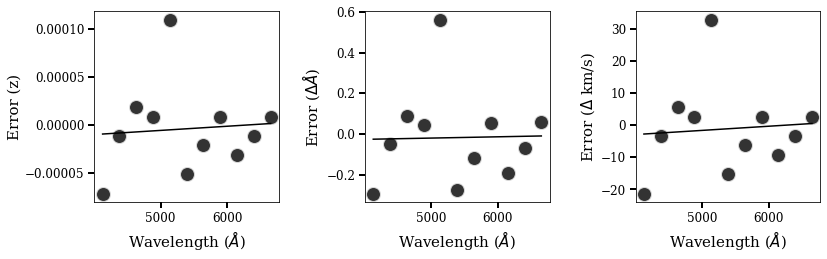

In [19]:
#Re-do redshifting to make sure correction worked
tm_result_corr, dered_wave = dered_corr(noflex_path, template_path, wave_corr, -0.000741, 0.005, 'coadd')
print(tm_result_corr[0])
norm_blue_wave_chunks_corr, norm_blue_flux_chunks_corr, norm_blue_noise_chunks_corr = data_chunks(dered_wave, data_cut_flux, 
                                                                                                  data_cut_noise,
                                                                                   250)
norm_template_wave_chunks_corr, norm_template_flux_chunks_corr, norm_template_noise_chunks_corr, \
template_central_wavelengths_corr, central_wavelengths_corr = template_chunks(dered_wave, data_cut_flux, data_cut_noise, 
                                                                         template_path, -0.000741, 250, 20, 'after')
QA_chunks(norm_blue_wave_chunks_corr, norm_blue_flux_chunks_corr, norm_template_wave_chunks_corr, 
          norm_template_flux_chunks_corr)
bestfit_redshift_corr, best_chi2_corr, redshifted_spectra_corr, chi2_corr = chunk_redshift(dered_wave, data_cut_flux, 
                                                                                           data_cut_noise, template_path, 
                                                                                           -0.000741, 250, 20, -0.001828, 0.005,
                                                                                          'after')
redshifted_waves_corr = []
redshifted_fluxes_corr = []
for i in range(len(redshifted_spectra_corr)):
    redshifted_waves_corr.append(redshifted_spectra_corr[i].spectral_axis)
    redshifted_fluxes_corr.append(redshifted_spectra_corr[i].flux)
QA_chunks(norm_blue_wave_chunks_corr, norm_blue_flux_chunks_corr, redshifted_waves_corr, redshifted_fluxes_corr)
QA_fit(bestfit_redshift_corr[:-1], central_wavelengths_corr[:-1])

And finally, we can define our final, flexure-corrected wavelength array for our blue data:

In [20]:
#Final corrected wavelength
corr_factor, blue_wave_corr = flexure_function(fit, -0.000741, data_wave_full)

Montonic:  True


### Red flexure correction
Here are all of the functions for the red flexure correction, and I will go through examples in detail below.

In [21]:
def read_1dspec(filename):
    """Return 1D wavelengths and extracted sky spectrum.
    
    Parameters
    ----------
    filename : str
        Path to 1D spectrum
    
    Returns
    -------
    wave : tuple
        Wavelength array
    sky_flux : tuple
        Extracted sky spectrum
    """
    
    file = fits.open(filename)
    data = file[1].data
    file.close()
    
    wave = data['OPT_WAVE']
    sky_flux = data['OPT_COUNTS_SKY']
    
    return wave, sky_flux

def read_skymod(filename):
    """Return skymodel.
    
    Parameters
    ----------
    filename : str
        Skymodel file
    
    Returns 
    -------
    wave : tuple
        Wavelength array
    sky_flux : tuple
        Skymodel spectrum
    """
    
    file = fits.open(filename)
    sky_flux = file[0].data
    wave = file[1].data
    file.close()
    
    return wave, sky_flux
    
def find_nearest(array, value):
    """Return the value in an array that is closest to the given value.
    
    Parameters
    ----------
    array : tuple
        Array to examine
    value : float
        Value to examine
        
    Returns
    -------
    array[idx] : float
        Value in array that is closest to value
    """
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return array[idx]
        
def gaussian(x, a, x0, sigma, d):
    """Returns a Gaussian fit.
    
    Parameters 
    ----------
    x : tuple
        x-values
    a : float
        Stretch value
    x0 : float
        Horizontal shift value
    sigma : float
        Standard deviation
    d : float
        Vertical shift value
        
    Returns
    -------
    a*np.exp(-(x-x0)**2/(2*sigma**2)) + d : tuple
        Gaussian fit
    """
    
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + d

def data_resolution(sky_wave, sky_flux):
    """Return estimated resolution of the data.
    
    Parameters
    ----------
    sky_wave : tuple
        Wavelength array
    sky_flux : tuple
        Flux array
    
    Returns
    -------
    R_red : float
        Estimated resolution
    """
    
    #Find FWHM of 4 lines across the spectrum and take the mean to find the resolution 
    line1 = [5575, 5585]
    line2 = [6300, 6305]
    line3 = [8346, 8348]
    line4 = [9377, 9380]

    line1_wave, line1_flux, line1_noise = continuum_normalize(line1[0], line1[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line1 = len(line1_wave)
    mean_line1 = np.mean(line1_wave)
    std_line1 = np.std(line1_wave)
    popt_line1, pcov_line1 = curve_fit(gaussian, line1_wave, line1_flux, p0=[np.max(line1_flux), mean_line1, std_line1, 0])
    FWHM_line1 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line1[2])

    line2_wave, line2_flux, line2_noise = continuum_normalize(line2[0], line2[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line2 = len(line2_wave)
    mean_line2 = np.mean(line2_wave)
    std_line2 = np.std(line2_wave)
    popt_line2, pcov_line2 = curve_fit(gaussian, line2_wave, line2_flux, p0=[np.max(line2_flux), mean_line2, std_line2, 0])
    FWHM_line2 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line2[2])

    line3_wave, line3_flux, line3_noise = continuum_normalize(line3[0], line3[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line3 = len(line3_wave)
    mean_line3 = np.mean(line3_wave)
    std_line3 = np.std(line3_wave)
    popt_line3, pcov_line3 = curve_fit(gaussian, line3_wave, line3_flux, p0=[np.max(line3_flux), mean_line3, std_line3, 0])
    FWHM_line3 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line3[2])

    line4_wave, line4_flux, line4_noise = continuum_normalize(line4[0], line4[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line4 = len(line4_wave)
    mean_line4 = np.mean(line4_wave)
    std_line4 = np.std(line4_wave)
    popt_line4, pcov_line4 = curve_fit(gaussian, line4_wave, line4_flux, p0=[np.max(line4_flux), mean_line4, std_line4, 0])
    FWHM_line4 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line4[2])
    
    R_red = np.mean((FWHM_line1, FWHM_line2, FWHM_line3, FWHM_line4))
    
    return R_red

def smooth_red(sky_wave, sky_flux):
    """Return sky spectrum smoothed to data resolution.
    
    Parameters
    ----------
    sky_wave : tuple
        Wavelength array
    sky_flux : tuple
        Flux array
    
    Returns
    -------
    smoothed_sky_flux : tuple
        Smoothed flux array
    smoothed_sky_noise : tuple
        Smoothed noise array
    """
    
    desired_blue_res, desired_red_res = lris_res(sky_wave[sky_wave <= 7000], sky_wave[sky_wave > 7000])
    desired_res = np.concatenate((desired_blue_res, desired_red_res))
    c = 299792.458 #speed of light
    
    #Smooth red 
    R_red = data_resolution(sky_wave, sky_flux)
    in_sigma_kms_red = (R_red/sky_wave)*c
    smoothed_sky_flux, smoothed_sky_noise = smooth_general(desired_res, in_sigma_kms_red/c*sky_wave, sky_wave, sky_flux, 
                                                           np.zeros_like(sky_flux))
    
    return smoothed_sky_flux, smoothed_sky_noise

def sky_centroids(sky_wave, smoothed_sky_flux, smoothed_sky_noise):
    """Returns centroids of skylines in the sky model.
    
    Parameters
    ----------
    sky_wave : tuple
        Wavelength array
    smoothed_sky_flux : tuple
        Smoothed flux array
    smoothed_sky_noise : tuple
        Smoothed noise array
        
    Returns
    -------
    sky_cents : tuple
        Skyline centroids
    """
    
    #Normalize sky model
    sky_norm_wave, sky_norm_flux, sky_norm_noise = continuum_normalize(np.min(sky_wave), np.max(sky_wave), smoothed_sky_flux, 
                                                                       sky_wave, smoothed_sky_noise)
    
    #Find centroids of skylines in model
    centroids = [7843, 7916, 7995.5, 8347, 8467, 8829.5, 8922, 9378, 9442, 9794]
    sky_bounds = [[7835, 7850], [7908, 7920], [7990, 8000], [8340, 8353], [8460, 8475], [8820, 8835], [8915, 8930], 
                      [9370, 9385], [9435, 9447], [9785, 9799]]

    sky = Spectrum1D(spectral_axis=sky_norm_wave*u.Angstrom, flux=sky_norm_flux*u.ct)
    regions_sky = []
    for i in range(len(sky_bounds)):
        regions_sky.append(SpectralRegion(sky_bounds[i][0]*u.Angstrom, sky_bounds[i][-1]*u.Angstrom))

    sky_cents = centroid(sky, regions_sky)
    
    return sky_cents

def centroid_offsets(targ_bounds, data_wave, data_flux, sky_cents):
    """Returns amount by which extracted skylines are offset from model and the nearest wavelength value to each.
    
    Parameters
    ----------
    targ_bounds : tuple
        List of tuples defining bounds of region around each skyline to examine
    data_wave : tuple
        Wavelength array
    data_flux : tuple
        Flux array
    sky_cents : tuple
        Skymodel centroids
        
    Returns
    -------
    nearest_waves : tuple
        Nearest wavelength value to centroid
    offsets : tuple
        Offset between data and skymodel
    """
    
    regions = SpectralRegion(targ_bounds[0][0]*u.Angstrom,targ_bounds[0][-1]*u.Angstrom)
    for i in range(1, len(targ_bounds)):
        regions += SpectralRegion(targ_bounds[i][0]*u.Angstrom, targ_bounds[i][-1]*u.Angstrom)

    #Normalize data
    targ_norm_wave, targ_norm_flux, targ_norm_noise = continuum_normalize(np.min(data_wave), np.max(data_wave), data_flux, 
                                                                          data_wave, np.zeros(len(data_flux)))
    
    
    #Find offsets
    target = Spectrum1D(spectral_axis=targ_norm_wave*u.Angstrom, flux=targ_norm_flux*u.ct)
    sub_spec = extract_region(target, regions)
    offsets = np.zeros(len(sky_cents))
    nearest_waves = np.zeros(len(sky_cents))
    for i, sub in enumerate(sub_spec):
        an_disp = sub.flux.max()
        an_ampl = sub.flux.min()
        an_mean = sub.spectral_axis[sub.flux.argmax()]
        nearest_waves[i] = an_mean.value
        an_stdv = np.sqrt(np.sum((sub.spectral_axis - an_mean)**2) / (len(sub.spectral_axis) - 1))

        plt.figure()
        plt.scatter(an_mean.value, an_disp.value, marker='o', color='#e41a1c', s=100, label='data')
        plt.scatter(sky_cents[i], an_disp.value, marker='o', color='k', s=100, label='archive')
        plt.vlines([an_mean.value - an_stdv.value, an_mean.value + an_stdv.value],
                    sub.flux.min().value, sub.flux.max().value,
                    color='#377eb8', ls='--', lw=2)
        g_init = ( models.Const1D(an_disp) +
                  models.Gaussian1D(amplitude=(an_ampl - an_disp),
                                mean=an_mean, stddev=an_stdv) )
        g_fit = fit_lines(sub, g_init)
        line_fit = g_fit(sub.spectral_axis)
        plt.plot(sub.spectral_axis, sub.flux, color='#e41a1c', lw=2)
        plt.plot(sub.spectral_axis, line_fit, color='#377eb8', lw=2)

        plt.axvline(an_mean.value, color='#e41a1c', ls='--', lw=2)
        plt.legend()
        offsets[i] = an_mean.value - sky_cents[i].value
        
    return nearest_waves, offsets

def offset_fit(nearest_waves, offsets):
    """Return straight line fit to offsets, to be applied to correct flexure.
    
    Parameters
    ----------
    nearest_waves : tuple
        Nearest wavelength value to centroid
    offsets : tuple
        Offset between data and skymodel
    
    Returns
    -------
    fit : np.polyfit object
        Fit to offsets in Angstroms
    fit_kms : np.polyfit object
        Fit to offsets in km/s
    fit_func : np.poly1d object
        Fit function in Angstroms
    fit_func_kms : np.poly1d object
        Fit function in km/s
    """
    
    c = 299792.458 #speed of light
    fit = np.polyfit(nearest_waves, offsets, 1)
    fit_kms = np.polyfit(nearest_waves, offsets/nearest_waves*c, 1)

    fit_func = np.poly1d(fit)
    fit_func_kms = np.poly1d(fit_kms)
    
    return fit, fit_kms, fit_func, fit_func_kms

def QA_offset_fit(nearest_waves, offsets):
    """Plot the offsets and fits to check fit.
    
    Parameters
    ----------
    nearest_waves : tuple
        Nearest wavelength value to centroid
    offsets : tuple
        Offset between data and skymodel
        
    Returns
    -------
    None
    """
    
    fit, fit_kms, fit_func, fit_func_kms = offset_fit(nearest_waves, offsets)
    c = 299792.458 #speed of light
    
    #Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    fig.set_tight_layout(True)
    
    #In Angstroms
    ax[0].plot(nearest_waves, offsets, linestyle='None', marker='.', markersize=30, mew=2, mec='w', alpha=0.8, color='k')
    ax[0].plot(nearest_waves, fit_func(nearest_waves), color='k', alpha=0.8)
    ax[0].tick_params(length=6, width=2, labelsize=12)
    ax[0].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[0].set_ylabel('Error ($\AA$)', fontsize=15)
    
    #In km/s
    ax[1].plot(nearest_waves, offsets/nearest_waves*c, linestyle='None', marker='.', markersize=30, mew=2, mec='w', 
             alpha=0.8, color='k')
    ax[1].plot(nearest_waves, fit_func_kms(nearest_waves), color='k', alpha=0.8)
    ax[1].tick_params(length=6, width=2, labelsize=12)
    ax[1].set_xlabel('Wavelength ($\AA$)', fontsize=20)
    ax[1].set_ylabel('Error (km/s)', fontsize=20)
    
def fit_interp(data_wave, data_flux, data_noise, nearest_waves, fit_func):
    """Return the flexure-corrected wavelengths.
    
    Parameters
    ----------
    data_wave : tuple
        Wavelength array
    data_flux : tuple
        Flux array
    data_noise : tuple
        Noise array
    nearest_waves : tuple
        Nearest wavelengths to centroids
    fit_func : np.poly1d object
        Fit to offsets in Angstroms
        
    Returns
    -------
    wave_corr : tuple
        Flexure-corrected wavelength array 
    """
    
    #Interpolate fits over wavelength range
    error_func = interp1d(nearest_waves, fit_func(nearest_waves), fill_value='extrapolate')
    corr_factor = error_func(data_wave)
    
    #Add correction factor to wavelength array
    wave_corr = data_wave - corr_factor
    
    #Make sure new wavelength arrays are monotonically increasing
    plt.figure(figsize=(8,7))
    plt.plot(data_wave, label='original', lw=3)
    plt.plot(wave_corr, label='corrected', linestyle='dashed')
    plt.xlabel('Pixel')
    plt.legend()
    plt.ylabel('Wavelength ($\AA$)')

    print('Monotonic: ', np.all(np.diff(wave_corr) > 0))
    
    return wave_corr

Again, this follows [`flexure_example.py`](https://github.com/chloe-mt-cheng/imf_css/blob/main/flexure_example.py).  First, we will read in the extracted sky spectrum from a 1D spectrum data file, as well as a sky model:

In [22]:
#Read in sky spectra
B058_old_red_file = 'spec1d_b161028_0048-B058-G119_LRISb_20161028T055539.504.fits'
sky_paranal_filename = 'paranal_sky.fits'

waves_1d_red, fluxes_1d_red = read_1dspec(B058_old_red_file)
sky_paranal_wave, sky_paranal_flux = read_skymod(sky_paranal_filename)

Now we need to find the resolution of the data and smooth the sky model to this resolution:

In [23]:
#Smooth the sky model
R_red = data_resolution(sky_paranal_wave, sky_paranal_flux)
smoothed_sky_flux, smoothed_sky_noise = smooth_red(sky_paranal_wave, sky_paranal_flux)

<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)


Find the centroids 

In [24]:
#Find sky centroids 
sky_cents = sky_centroids(sky_paranal_wave, smoothed_sky_flux, smoothed_sky_noise)

/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-21-1cfcd589ccef>:197: RankWarning: Polyfit may be poorly conditioned
  sky_norm_wave, sky_norm_flux, sky_norm_noise = continuum_normalize(np.min(sky_wave), np.max(sky_wave), smoothed_sky_flux,
<ipython-input-21-1cfcd589ccef>:197: RankWarning: Polyfit may be poorly conditioned
  sky_norm_wave, sky_norm_flux, sky_norm_noise = continuum_normalize(np.min(sky_wave), np.max(sky_wave), smoothed_sky_flux,
<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)


Compute the offsets between the extracted sky spectrum and the sky model

In [25]:
#Get offsets between data and model
red_targ_bounds = [[7835, 7850], [7910, 7922], [7990, 8000], [8340, 8353], [8460, 8475], [8823, 8833], 
                   [8918, 8925], [9370, 9385], [9435, 9447], [9790, 9798]]
nearest_waves, offsets = centroid_offsets(red_targ_bounds, waves_1d_red, fluxes_1d_red, sky_cents)

<ipython-input-21-1cfcd589ccef>:241: RankWarning: Polyfit may be poorly conditioned
  targ_norm_wave, targ_norm_flux, targ_norm_noise = continuum_normalize(np.min(data_wave), np.max(data_wave), data_flux,
<ipython-input-21-1cfcd589ccef>:241: RankWarning: Polyfit may be poorly conditioned
  targ_norm_wave, targ_norm_flux, targ_norm_noise = continuum_normalize(np.min(data_wave), np.max(data_wave), data_flux,
<ipython-input-3-f8675306da59>:96: RuntimeWarning: invalid value encountered in true_divide
  noise_norm = noise_inrange/poly_obj_noise(xrange)


ValueError: zero-size array to reduction operation maximum which has no identity

Plot these offsets and fit a straight line to them - this will be your flexure correction function 

In [ ]:
#Fit the errors
fit, fit_kms, fit_func, fit_func_kms = offset_fit(nearest_waves, offsets)
QA_offset_fit(nearest_waves, offsets)

Remember, you have only been working with a 1D spectrum extracted sky spectrum.  You will need to apply this flexure correction function to your red coadded spectrum:

In [ ]:
#Import co-added spectra
B058_red_coadd = fits.open('B058_red_coadd1d.fits')
B058_red_coadd_wave = B058_red_coadd[1].data['wave']
B058_red_coadd_flux = B058_red_coadd[1].data['flux']
B058_red_coadd_noise = np.sqrt(B058_red_coadd[1].data['ivar'])
B058_red_coadd.close()

#Correct the wavelength
wave_corr = fit_interp(B058_red_coadd_wave, B058_red_coadd_flux, B058_red_coadd_noise, nearest_waves, fit_func)

Again, we'll re-run all of the above chunks of code but with the flexure-corrected wavelength array to check the quality of our flexure correction.

In [ ]:
#Re-do to check if correction worked
waves_1d_red_corr = fit_interp(waves_1d_red, fluxes_1d_red, np.zeros_like(fluxes_1d_red), nearest_waves, fit_func)

red_targ_bounds_corr = [[7835, 7850], [7910, 7922], [7990, 8000], [8340, 8353], [8460, 8475], [8824, 8835], [8918, 8925], 
                   [9370, 9385], [9437, 9448], [9790, 9798]]
nearest_waves_corr, offsets_corr = centroid_offsets(red_targ_bounds_corr, waves_1d_red_corr, fluxes_1d_red, sky_cents)

fit_corr, fit_corr_kms, fit_func_corr, fit_func_corr_kms = offset_fit(nearest_waves_corr, offsets_corr)
QA_offset_fit(nearest_waves_corr, offsets_corr)

This completes your flexure correction and we can now move on to telluric correction.

## Telluric Correction
We tellurically-correct our data using the formalism in van Dokkum et al. 2017.  You can find all of these functions in [`telluric_correction.py`](https://github.com/chloe-mt-cheng/imf_css/blob/main/telluric_correction.py), but I will go through a detailed example here.

First, let's do some imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import sys
import glob
from sedpy.observate import air2vac
from prospect import utils
from scipy.interpolate import interp1d
import scipy.optimize as op
from scipy.stats import chisquare
import pandas as pd

font = {'family':'serif',
        'weight':'normal',
        'size':20
}
plt.rc('font',**font)

Now I'll put down all of the telluric correction functions that you'll need.  

In [ ]:
#Alexa's wavelength-dependent resolution function
def lris_res(lb, lr):
    """Get wavelength dependent resolution.
    
    Parameters
    ----------
    lb, lr : Arrays of blue and red wavelengths in angstroms in vacuum.
    
    Returns
    -------
    resb, resr : Resolution in km/s
    """
    
    resb = 3.09 + 0.187*(lb - 5000.)/1000. #res in A
    resb = resb/lb*3.e5 #res in km/s
    l9 = (lr - 9000.)/1000.
    resr = 1.26 - 0.128*l9 + 0.168*l9**2 + 0.1173*l9**3
    resr = resr/lr*3.E5
    
    return resb, resr
    
    
def normalize(wavelength, flux):
    """Return a normalized spectrum using a 4th-order polynomial (used old continuum-normalization code
    as a model).
    
    Parameters
    ----------
    wavelength : tuple
        Wavelength array
    flux : tuple
        Flux array
        
    Returns
    -------
    flux_norm : tuple
        Normalized flux
    """
    
    #Fit a 4th-order polynomial to the spectrum
    lambda_min = np.min(wavelength)
    lambda_max = np.min(wavelength)
    xrange = np.linspace(np.min(lambda_min), np.max(lambda_max), len(wavelength))
    polynomial_fit = np.polyfit(xrange, flux, 4)
    poly_obj = np.poly1d(polynomial_fit)
    
    #Divide out the fitted polynomial to get a continuum-normalized spectrum
    flux_norm = flux/poly_obj(xrange)
    
    return flux_norm
    
    
def minimization(f, correction_template_flux, correction_gal_flux):
	"""Minimization for scipy.optimize.minimize to find the scale factor between the template and target spectra.
	
	Parameters
	----------
	f : float
		Initial guess for scale factor
	correction_template_flux : tuple
		Flux array over minimization range for the template
	correction_gal_flux : tuple
		Flux array over minimization range for target
		
	Returns
	-------
	np.max(np.abs(correction_gal_flux - Tf)) : float
		The maximum absolute difference between the target flux and scaled template flux
	"""
	
	#Scale the template flux 
	Tf = 1 + f*(correction_template_flux - 1)
	
	#Minimize
	return np.max(np.abs(correction_gal_flux - Tf))
    
    
def Tf(f, T0):
    """Return the scaled template spectrum.
    
    Parameters
    ----------
    f : float
        Scale parameter
    T0 : tuple
        Template atmospheric transmission spectrum
    
    Returns
    -------
    1 + f*(T0 - 1) : tuple
        Scaled template spectrum
    """
    
    return 1 + f*(T0 - 1)


def telluric_correction(blue_path, red_path, template_wave, template_flux):
    """Return the tellurically-corrected flux and corresponding wavelength for a reduced object.
    Parameters
    ----------
    blue_path : str
        Path to the blue coadded spectrum
    red_path : str
        Path to the red coadded spectrum
    Returns
    -------
    total_target_wave : tuple
        Wavelength array
    telluric_corrected_flux : tuple
        Tellurically-corrected flux array
    """

    #Import co-added target spectra
    blue_coadd1d = fits.open(blue_path)
    blue_dat = blue_coadd1d[1].data
    blue_coadd1d.close()

    red_coadd1d = fits.open(red_path)
    red_dat = red_coadd1d[1].data
    red_coadd1d.close()

    #Get wavelengths and fluxes for target and template
    target_blue_wave = blue_dat['wave']
    target_red_wave = red_dat['wave']
    target_blue_flux = blue_dat['flux']
    target_red_flux = red_dat['flux']
    target_blue_ivar = blue_dat['ivar']
    target_red_ivar = red_dat['ivar']
    target_noise = 1/np.sqrt(np.concatenate((target_blue_ivar, target_red_ivar)))

    template_blue_wave = template_wave[(template_wave >= np.min(target_blue_wave)) & (template_wave <= np.max(target_blue_wave))]
    template_red_wave = template_wave[(template_wave >= np.min(target_red_wave)) & (template_wave <= np.max(target_red_wave))]
    template_blue_flux = template_flux[(template_wave >= np.min(target_blue_wave)) & (template_wave <= np.max(target_blue_wave))]
    template_red_flux = template_flux[(template_wave >= np.min(target_red_wave)) & (template_wave <= np.max(target_red_wave))]

    #Get resolution using wavelength ranges from target object
    resb_template, resr_template = lris_res(template_blue_wave, template_red_wave)

    #Concatenate into one wavelength range
    total_template_res = np.concatenate((resb_template, resr_template))
    total_template_wave = np.concatenate((template_blue_wave, template_red_wave))
    total_template_flux = np.concatenate((template_blue_flux, template_red_flux))
    total_target_wave = np.concatenate((target_blue_wave, target_red_wave))
    total_target_flux = np.concatenate((target_blue_flux, target_red_flux))

    #Convert telluric resolution to km/s
    c = 299792.458 #speed of light
    R = 20000 #instrument resolution
    inval = total_template_wave/R
    in_sigma = inval/2.*np.sqrt(2.*np.log(2))
    in_sigma_kms = (in_sigma/total_template_wave)*c

    #Smooth template spectrum
    sigma_aa_desired = total_template_res/c*total_template_wave
    sigma_aa_original = in_sigma_kms/c*total_template_wave
    delta_sigma_aa_vector = np.sqrt(sigma_aa_desired**2 - sigma_aa_original**2)
    smoothed_template_flux = utils.smoothing.smoothspec(total_template_wave, total_template_flux, outwave=total_template_wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, fftsmooth=True)

    #Re-grid template spectrum by interpolating onto target wavelength grid
    regrid_template_flux = np.interp(total_target_wave, total_template_wave, smoothed_template_flux)

    #Normalize the target and template spectra over 9250-9650A
    normrange_wave = total_target_wave[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normrange_target_flux = total_target_flux[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normrange_template_flux = regrid_template_flux[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normed_template_flux = normalize(normrange_wave, normrange_template_flux)
    normed_target_flux = normalize(normrange_wave, normrange_target_flux)

    #Do the minimization over 9320-9380A
    correction_wave = normrange_wave[(normrange_wave >= 9320) & (normrange_wave <= 9380)]
    correction_template_flux = normed_template_flux[(normrange_wave >= 9320) & (normrange_wave <= 9380)]
    correction_target_flux = normed_target_flux[(normrange_wave >= 9320) & (normrange_wave <= 9380)]

    x0 = 1 #Initial guess
    res = op.minimize(minimization, x0, args=(correction_template_flux, correction_target_flux), method='Nelder-Mead', tol=1e-6)
    #print(res)

    #Get the chi-squared value for the fit
    corrected_template_flux = Tf(res.x, correction_template_flux)
    residuals = ((correction_target_flux - corrected_template_flux)/correction_target_flux)*100
    cdist = np.sort(residuals)
    chisq_val, p_val = chisquare(cdist)

    #Scale the template spectrum by the best-fit scale factor 
    scaled_template_flux = Tf(res.x, regrid_template_flux)

    return total_target_wave, scaled_template_flux, chisq_val, total_target_flux

def best_template(blue_path, red_path, template_wave, template_fluxes):
    scaled_dat = []
    for i in range(len(template_fluxes)):
        for j in range(len(template_fluxes[i])):
            for k in range(len(template_fluxes[i][j])):
                for l in range(len(template_fluxes[i][j][k])):
                    scaled_dat.append(telluric_correction(blue_path, red_path, template_wave, 
                                                          template_fluxes[i][j][k][l]))
    scaled_dat = np.array(scaled_dat)
    scaled_wave = scaled_dat[:,0]
    scaled_flux = scaled_dat[:,1]
    chisquares = scaled_dat[:,2]
    target_flux = scaled_dat[:,3]
    
    best_scaled_template = scaled_flux[np.argmin(chisquares)]
    tell_flux = target_flux[np.argmin(chisquares)]/best_scaled_template
    tell_wave = scaled_wave[np.argmin(chisquares)]
    return best_scaled_template, tell_flux, tell_wave

#Tellurically-correct new spectra
def telluric_correction_routine(blue_path, red_path):
    #Import telluric grid
    file = '/Applications/anaconda3/lib/python3.8/site-packages/pypeit/data/telluric/TelFit_MaunaKea_3100_26100_R20000.fits'
    hdul = fits.open(file)
    header0 = hdul[0].header
    data0 = hdul[0].data #flux
    header1 = hdul[1].header
    data1 = hdul[1].data #wavelength
    hdul.close()
    template_wave = data1*10 #Convert from nm to A
    template_fluxes = data0
                    
    #Scale the template spectra
    scaled_template, tell_flux, tell_wave = best_template(blue_path, red_path, template_wave, template_fluxes)
    return tell_flux, tell_wave, scaled_template

To run the telluric correction on the above flexure-corrected example data, you can run the following.  It will take a little while to run

In [ ]:
#Telluric correction
B058_blue_path = 'B058_blue_coadd1d.fits'
B058_red_path = 'B058_red_coadd1d.fits'
B058_tell_flux, B058_tell_wave, B058_scaled_template, B058_targ_flux = telluric_correction_routine(B058_blue_path, 
                                                                                                   B058_red_path, 
                                                                                                   B058_blue_final_corr_wave, 
                                                                                                   B058_red_wave_corr)
B058_total_corrected_wave = np.concatenate((B058_blue_final_corr_wave, B058_red_wave_corr))
B058_total_noise = np.concatenate((1/np.sqrt(B058_noise_full), B058_red_coadd_noise))
B058_total_flux = np.concatenate((B058_flux_full, B058_red_coadd_flux))

You can check the quality of your telluric correction with the following:

In [26]:
#Normalize the spectra over these ranges to check some key spectral regions
#This uses the same continuum-normalization code as above, in the flexure correction section
feature_6300_range = [5800, 6700]
feature_8200_range = [8000, 8400]
feature_9700_range = [9600, 9900]
correction_range = [9320, 9380]

#Note we don't actually need the noise here so it's just noise everywhere
#Pre-telluric correction
norm_wave_B058_raw_correction, norm_flux_B058_raw_correction, noise = continuum_normalize(correction_range[0], 
                                                                                          correction_range[-1], 
                                                                                          B058_targ_flux, 
                                                                                          B058_total_corrected_wave,
                                                                                          B058_total_noise)
norm_wave_B058_raw_6300, norm_flux_B058_raw_6300, noise = continuum_normalize(feature_6300_range[0], 
                                                                              feature_6300_range[-1], 
                                                                              B058_targ_flux, 
                                                                              B058_total_corrected_wave, 
                                                                              B058_total_noise)
norm_wave_B058_raw_8200, norm_flux_B058_raw_8200, noise = continuum_normalize(feature_8200_range[0], 
                                                                              feature_8200_range[-1], 
                                                                              B058_targ_flux, 
                                                                              B058_total_corrected_wave, 
                                                                              B058_total_noise)
norm_wave_B058_raw_9700, norm_flux_B058_raw_9700, noise = continuum_normalize(feature_9700_range[0], 
                                                                              feature_9700_range[-1], 
                                                                              B058_targ_flux, 
                                                                              B058_total_corrected_wave, 
                                                                              B058_total_noise)

#Post-telluric correction
norm_wave_B058_tell_correction, norm_flux_B058_tell_correction, noise = continuum_normalize(correction_range[0],
                                                                                            correction_range[-1], 
                                                                                            B058_tell_flux, 
                                                                                            B058_tell_wave, 
                                                                                            B058_total_noise)
norm_wave_B058_tell_6300, norm_flux_B058_tell_6300, noise = continuum_normalize(feature_6300_range[0], 
                                                                                feature_6300_range[-1], 
                                                                                B058_tell_flux, 
                                                                                B058_tell_wave, 
                                                                                B058_total_noise)
norm_wave_B058_tell_8200, norm_flux_B058_tell_8200, noise = continuum_normalize(feature_8200_range[0],
                                                                                feature_8200_range[-1], 
                                                                                B058_tell_flux, 
                                                                                B058_tell_wave, B058_total_noise)
norm_wave_B058_tell_9700, norm_flux_B058_tell_9700, noise = continuum_normalize(feature_9700_range[0], 
                                                                                feature_9700_range[-1], 
                                                                                B058_tell_flux, 
                                                                                B058_tell_wave, B058_total_noise)

#Scaled templates
norm_wave_B058_scale_correction, norm_flux_B058_scale_correction, noise = continuum_normalize(correction_range[0],
                                                                                              correction_range[-1],
                                                                                              B058_scaled_template,
                                                                                              B058_tell_wave, 
                                                                                              B058_total_noise)
norm_wave_B058_scale_6300, norm_flux_B058_scale_6300, noise = continuum_normalize(feature_6300_range[0], 
                                                                                  feature_6300_range[-1], 
                                                                                  B058_scaled_template, 
                                                                                  B058_tell_wave, 
                                                                                  B058_total_noise)
norm_wave_B058_scale_8200, norm_flux_B058_scale_8200, noise = continuum_normalize(feature_8200_range[0], 
                                                                                  feature_8200_range[-1], 
                                                                                  B058_scaled_template,
                                                                                  B058_tell_wave, 
                                                                                  B058_total_noise)
norm_wave_B058_scale_9700, norm_flux_B058_scale_9700, noise = continuum_normalize(feature_9700_range[0], 
                                                                                  feature_9700_range[-1], 
                                                                                  B058_scaled_template,
                                                                                  B058_tell_wave, 
                                                                                  B058_total_noise)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(24, 16))
fig.set_tight_layout(True)
ax[0,0].plot(norm_wave_B058_raw_correction, norm_flux_B058_raw_correction+0.5, color='orange', lw=2, 
             label='Pre-Telluric')
ax[0,0].plot(norm_wave_B058_scale_correction, norm_flux_B058_scale_correction+0.5, color='dimgrey', lw=2, 
         label='Scaled Template, Original Range')
ax[0,0].tick_params(length=6, width=2, labelsize=12)
ax[0,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)
ax[0,0].legend(fontsize=12, framealpha=0)
ax[0,0].set_xlim(9320, 9380)

ax[1,0].plot(norm_wave_B058_raw_6300, norm_flux_B058_raw_6300+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[1,0].plot(norm_wave_B058_scale_6300, norm_flux_B058_scale_6300+0.5, color='dimgrey', lw=2, 
             label='Scaled Template')
ax[1,0].tick_params(length=6, width=2, labelsize=12)
ax[1,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)

ax[2,0].plot(norm_wave_B058_raw_8200, norm_flux_B058_raw_8200+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[2,0].plot(norm_wave_B058_scale_8200, norm_flux_B058_scale_8200+0.5, color='dimgrey', lw=2, 
             label='Scaled Template')
ax[2,0].tick_params(length=6, width=2, labelsize=12)
ax[2,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)

ax[3,0].plot(norm_wave_B058_raw_9700, norm_flux_B058_raw_9700+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[3,0].plot(norm_wave_B058_scale_9700, norm_flux_B058_scale_9700+0.5, color='dimgrey', lw=2, 
             label='Scaled Template')
ax[3,0].tick_params(length=6, width=2, labelsize=12)
ax[3,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)
ax[3,0].set_xlabel('Wavelength ($\AA$)', fontsize=15)

ax[0,1].plot(norm_wave_B058_raw_correction, norm_flux_B058_raw_correction+0.5, color='orange', lw=2, 
             label='Pre-Telluric')
ax[0,1].plot(norm_wave_B058_tell_correction, norm_flux_B058_tell_correction+0.5, color='r', alpha=0.7, lw=2, 
         label='Post-Telluric, Original Range')
ax[0,1].tick_params(length=6, width=2, labelsize=12)
ax[0,1].legend(fontsize=12, framealpha=0)
ax[0,1].set_xlim(9320, 9380)

ax[1,1].plot(norm_wave_B058_raw_6300, norm_flux_B058_raw_6300+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[1,1].plot(norm_wave_B058_tell_6300, norm_flux_B058_tell_6300+0.5, color='r', alpha=0.7, lw=2, 
             label='tell2d Template')
ax[1,1].tick_params(length=6, width=2, labelsize=12)

ax[2,1].plot(norm_wave_B058_raw_8200, norm_flux_B058_raw_8200+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[2,1].plot(norm_wave_B058_tell_8200, norm_flux_B058_tell_8200+0.5, color='r', alpha=0.7, lw=2, 
             label='tell2d Template')
ax[2,1].tick_params(length=6, width=2, labelsize=12)

ax[3,1].plot(norm_wave_B058_raw_9700, norm_flux_B058_raw_9700+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[3,1].plot(norm_wave_B058_tell_9700, norm_flux_B058_tell_9700+0.5, color='r', alpha=0.7, lw=2, 
             label='tell2d Template')
ax[3,1].tick_params(length=6, width=2, labelsize=12)
ax[3,1].set_xlabel('Wavelength ($\AA$)', fontsize=15)

NameError: name 'B058_targ_flux' is not defined

# Preparing Data to be Fit with alf (Optional)
If you plan to fit your data using [alf](https://github.com/cconroy20/alf) (Conroy & van Dokkum 2012, Conroy et al. 2018), there are some additional steps you must take to prepare your data.  These include:
1. Smoothing your data
2. Preparing your .dat file